In [65]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import h5py
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)

def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []

    with h5py.File(hdf5_file, 'r') as f:
        # Access the dataset
        dataset = f[dataset_name]

        # Extract the 'group', 'x', and 'y' fields
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]

        # Find unique groups
        unique_groups = np.unique(group_data)

        # Collect data for each group
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

def find_clusters_k_means(data, k):
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=4)
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    distances = []
    for i in range(4):
        line_start = rectangle[i]
        line_end = rectangle[(i + 1) % 4]
        distances.append(np.mean([distance_to_line(point, line_start, line_end) for point in points]))
    closest_side = np.argmin(distances)
    return closest_side

def find_rotation_angle(rectangle, closest_side):
    # Find the angle of the closest side to make it parallel to the x-axis
    closest_line_start = rectangle[closest_side]
    closest_line_end = rectangle[(closest_side + 1) % 4]
    
    # Debugging: Print the coordinates of the closest line
    print(f"Closest line start: {closest_line_start}, end: {closest_line_end}")
    
    angle = np.arctan2(closest_line_end[1] - closest_line_start[1], closest_line_end[0] - closest_line_start[0])
    
    # Debugging: Print the initial calculated angle
    print(f"Initial calculated angle: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Ensure the longer side is at the top (if not, adjust the angle by 90 degrees)
    if rectangle[1][0] < rectangle[1][1]:
        angle += np.pi / 2
        print(f"Adjusted angle by 90 degrees: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Determine if the closest edge is the top or bottom edge
    if closest_line_start[1] < closest_line_end[1]:  # If the closest side is the bottom side
        angle += np.pi  # Rotate by 180 degrees to move it to the top
        print(f"Adjusted angle by 180 degrees (for bottom side): {angle} radians ({np.degrees(angle)} degrees)")
    
    final_angle = -angle  # Negate to rotate in the correct direction
    
    # Debugging: Print the final rotation angle
    print(f"Final rotation angle: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    return final_angle

def adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side):
    """
    Adjust the final orientation of the image by comparing the y-values of the closest side 
    before and after rotating by an additional 180 degrees.
    """
    # Calculate the y-values of the closest edge
    closest_line_start = rotated_rect[closest_side]
    closest_line_end = rotated_rect[(closest_side + 1) % 4]
    avg_y_before = (closest_line_start[1] + closest_line_end[1]) / 2
    
    # Perform a 180-degree rotation
    rotated_data_180 = rotate_points(rotated_com, np.pi, find_center_of_rectangle(rotated_rect))
    rotated_rect_180 = rotate_points(rotated_rect, np.pi, find_center_of_rectangle(rotated_rect))
    
    # Calculate the y-values of the rotated edge after the 180-degree rotation
    closest_line_start_180 = rotated_rect_180[closest_side]
    closest_line_end_180 = rotated_rect_180[(closest_side + 1) % 4]
    avg_y_after = (closest_line_start_180[1] + closest_line_end_180[1]) / 2
    
    # Compare the average y-values and choose the orientation with the higher y-value
    if avg_y_after < avg_y_before:
        print("Adjusting by 180 degrees")
        return rotated_data_180, rotated_rect_180, rotation_angle + np.pi
    else:
        return rotated_com, rotated_rect, rotation_angle



def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points



def find_middle_left_most_com(rotated_com):
    # Sort each com in rotated_com based on its x value and take the first 3
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    second_highest_com = None
    
    # Find the second highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_coms(rotated_com):
    # Sort each com in rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()]
    right_most_com = sorted_com[-1]
    second_right_most_com = sorted_com[-2]
    return right_most_com, second_right_most_com

def find_center_of_rectangle(rectangle):
    return np.mean(rectangle, axis=0)


def find_robot(rotated_com):
    
    #finding the center of the rectangle
    center_x, center_y = find_center_of_rectangle(rotated_com)
    
    distances = np.sqrt((rotated_com[:, 0] - center_x) ** 2 + (rotated_com[:, 1] - center_y) ** 2)
    closest_com_index = np.argmin(distances)
    closest_com = rotated_com[closest_com_index]
    
    return closest_com
#drawing line between two points without using cv2
def draw_line_between_points(p1, p2, color='white'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    
def intersection_between_point_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    if x1 == x2:
        return x1, y0
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    x = (m * y0 + x0 - m * c) / (m ** 2 + 1)
    y = m * x + c
    return x, y
    

def draw_line_between_point_and_line( p1, p2, p3):
    
    #finding the intersection point
    right_line = np.array([p1, p2])
    intersection_x, intersection_y = intersection_between_point_line(p3, right_line)
    intersection_point = np.array([intersection_x, intersection_y])
    
    #plotting the points between the points p3 and intersection point
    plt.plot([p3[0], intersection_point[0]], [p3[1], intersection_point[1]], color='magenta')

def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com):
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    right_line = np.array([right_most_com, second_right_most_com])
    intersection_point = intersection_between_point_line(robot_com, right_line)
    normalizing_point = intersection_between_point_line(second_highest_com, right_line)
    robot_distance = distance_point_to_line(robot_com, right_line)
    normalizing_distance = distance_point_to_line(second_highest_com, right_line)
    ratio = robot_distance / normalizing_distance

    plt.axes().set_facecolor('black')
    ax = plt.gca()
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=10)
    plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=10)
    plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=10)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=10)
    plt.scatter(robot_com[0], robot_com[1], color='magenta', s=10)

    draw_line_between_points(right_most_com, second_right_most_com, color='magenta')
    draw_line_between_point_and_line(right_most_com, second_right_most_com, robot_com)
    draw_line_between_point_and_line(second_right_most_com, right_most_com, second_highest_com)

    plt.show()

    return ratio


In [58]:
def plot_helper(data=None, labels=None, com=None, rotated_data=None, rotated_com=None, rotated_rect=None, second_highest_com=None, right_most_com=None, second_right_most_com=None, robot_com=None, title="Plot"):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    
    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)
    
    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')
    
    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    
    if rotated_com is not None and rotated_com.size > 0:
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100, label='Rotated COMs')
   
    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                     [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

    if second_highest_com is not None and len(second_highest_com) > 0:
        plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=100, label='Second Highest COM')
    

    if right_most_com is not None and len(right_most_com) > 0:
        plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=100, label='Right Most COM')
   
    if second_right_most_com is not None and len(second_right_most_com) > 0:
        plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=100, label='Second Right Most COM')
    
    if robot_com is not None and len(robot_com) > 0:
        plt.scatter(robot_com[0], robot_com[1], color='magenta', s=100, label='Robot COM')
    
    
    plt.title(title)
    plt.legend()
    plt.show()




def process_origami_ratio(filename, k):
    print("Starting process_origami_ratio")
    
    data = collect_data(filename)
    print("Data collected:\n", data.head())
    plot_helper(data=data, title="Initial Data")
    
    labels = find_clusters_k_means(data, k)
    print("K-Means labels:\n", labels)
    plot_helper(data=data, labels=labels, title="K-Means Clustering")

    com = find_com(data, labels)
    print("Centers of Mass (COM):\n", com)
    plot_helper(data=data, labels=labels, com=com, title="Centers of Mass")

    min_bounding_rect = minimum_bounding_rectangle(np.array(com))
    print("Minimum Bounding Rectangle:\n", min_bounding_rect)
    
    closest_side = find_closest_side(np.array(com), min_bounding_rect)
    print("Closest side of bounding rectangle:\n", closest_side)
    
    rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
    print("Rotation angle:\n", rotation_angle)
    
    rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Data:\n", rotated_data[:5])
    
    rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Centers of Mass (COM):\n", rotated_com)
    
    rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
    
    # Adjust the final orientation if needed
    rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
    if (rotation_angle != final_angle):
        #totae the data points by 180 degrees
        rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
    print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Final Adjusted Data and COMs")

    second_highest_com = find_middle_left_most_com(rotated_com)
    print("Second Highest COM:\n", second_highest_com)
    
    right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
    print("Right Most COM:\n", right_most_com)
    print("Second Right Most COM:\n", second_right_most_com)
    
    robot_com = find_robot(rotated_com)
    print("Robot COM:\n", robot_com)

    ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
    print("Ratio:\n", ratio)
    
    

    return ratio


Starting process_origami_ratio
Data collected:
             x          y
0  111.875267  60.029800
1  111.827614  60.045071
2  111.803627  60.154224
3  111.851440  60.342262
4  111.837921  60.320156


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


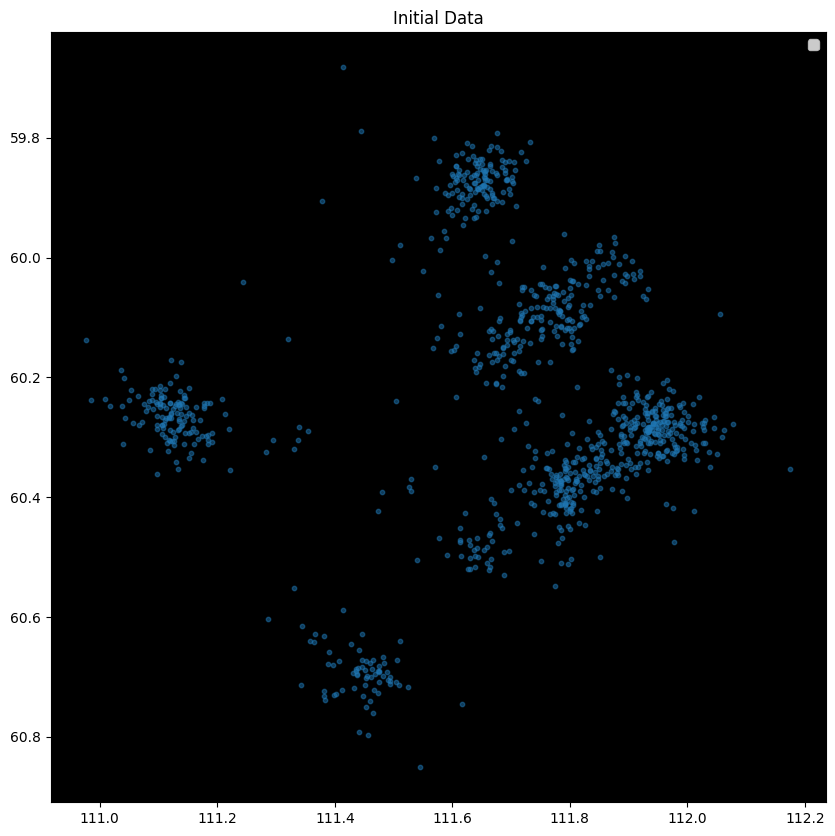

K-Means labels:
 [5 5 5 6 6 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 5 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 5 5 5 4 1 1 1 1 5
 5 5 5 5 5 5 5 5 5 5 2 2 2 3 3 3 3 3 6 6 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 4 6
 6 0 0 0 0 0 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 0 7 6 0 0 0 0 0 0 0 0 0 0 0 4 6 6 0 0 7 1 0 0 2 2 2 2 1 1 6
 6 6 6 1 2 2 6 6 6 6 6 6 0 0 6 6 1 1 1 1 1 1 2 4 4 6 6 0 0 0 0 0 0 0 6 0 6
 0 6 6 6 6 6 6 6 5 4 4 4 4 4 4 4 4 4 4 5 5 5 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 6 6 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 7 7 6 7 7 7 7 5
 5 2 2 2 1 1 1 1 1 1 1 5 5 4 4 4 0 0 0 7 7 7 7 7 7 7 7 7 1 1 1 1 1 4 1 1 1
 1 2 2 6 6 7 7 7 7 7 7 7 7 7 7 7 7 3 3 2 2 2 2 2 2 2 4 4 4 4 4 4 7 2 0 0 0
 6 6 6 4 4 4 4 2 2 2 2 2 2 2 2 2 2 1 2 5 5 5 5 5 5 3 3 3 3 1 0 0 0 0 0 3 3
 2 4 5 5 5 7 6 6 4 1 1 6 6 6 6 0 0 1 1 5 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 5 0 0 0 0 4 4
 4 4 4 7

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


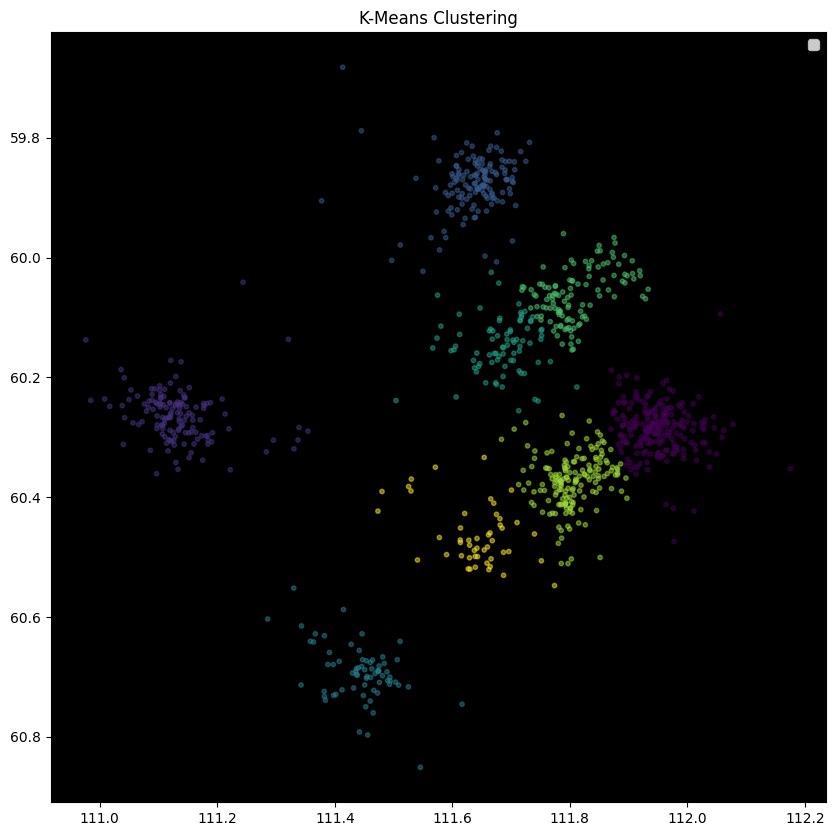

Centers of Mass (COM):
 [(np.float32(111.95023), np.float32(60.285942)), (np.float32(111.1327), np.float32(60.26338)), (np.float32(111.6368), np.float32(59.877396)), (np.float32(111.443954), np.float32(60.693012)), (np.float32(111.68343), np.float32(60.147842)), (np.float32(111.811005), np.float32(60.06247)), (np.float32(111.805565), np.float32(60.373165)), (np.float32(111.6388), np.float32(60.46383))]


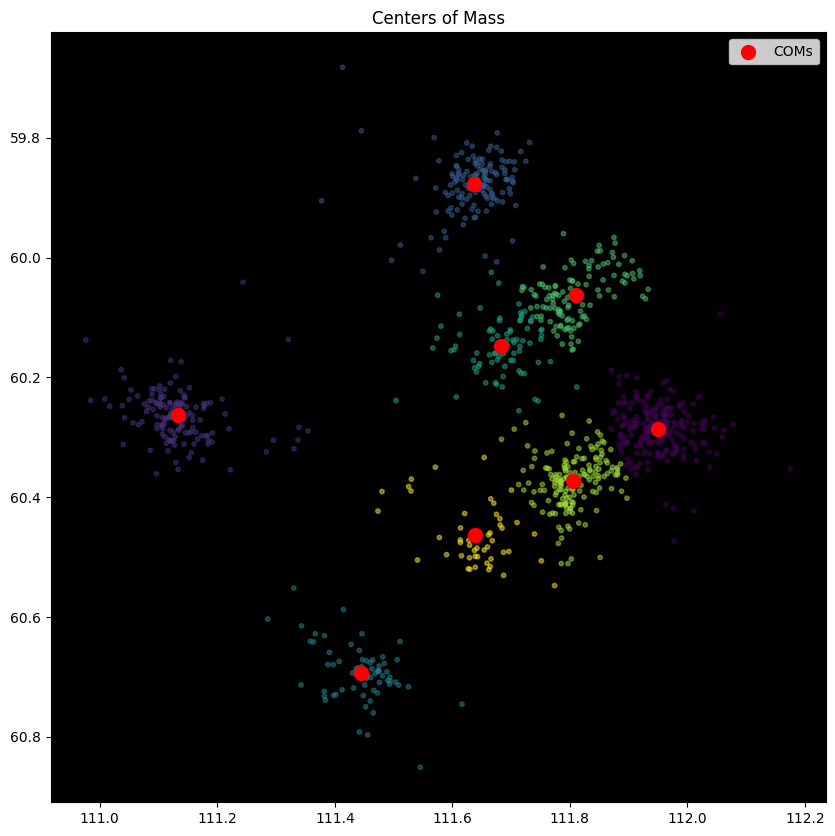

Minimum Bounding Rectangle:
 [[111.97969055  60.2828064 ]
 [111.65727234  59.86171722]
 [111.121521    60.27193069]
 [111.44393921  60.69301987]]
Closest side of bounding rectangle:
 3
Closest line start: [111.44393921  60.69301987], end: [111.97969055  60.2828064 ]
Initial calculated angle: -0.653460287914256 radians (-37.44051657689051 degrees)
Final rotation angle: 0.653460287914256 radians (37.44051657689051 degrees)
Rotation angle:
 0.653460287914256
Rotated Data:
 [[112.18960294  60.42865396]
 [112.14248367  60.41180813]
 [112.05707985  60.48389208]
 [111.98072771  60.66225888]
 [111.98343277  60.63648803]]
Rotated Centers of Mass (COM):
 [[112.09340704  60.67760148]
 [111.45801373  60.16267567]
 [112.09291841  60.16267545]
 [111.44395596  60.69302309]
 [111.96552789  60.40575476]
 [112.11871882  60.4155252 ]
 [111.92551621  60.65890582]
 [111.73799068  60.62950994]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 3.795052941504049 radians (217.4405165768905 degre

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


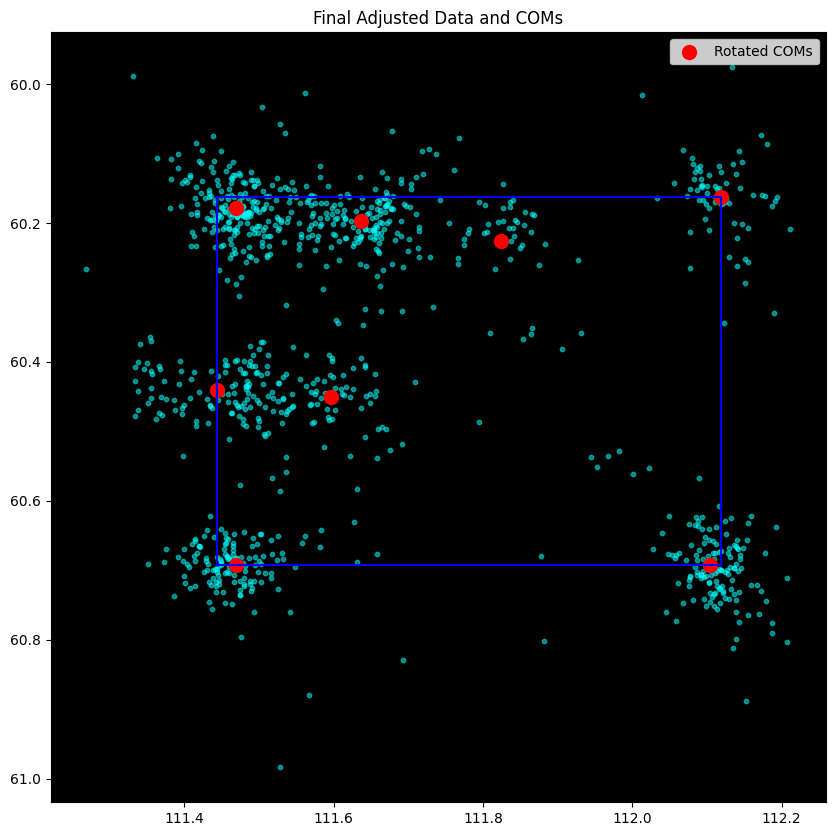

Second Highest COM:
 [111.4439229   60.44016598]
Right Most COM:
 [112.11868576  60.16266809]
Second Right Most COM:
 [112.10462799  60.69301551]
Robot COM:
 [111.59711383  60.44993642]


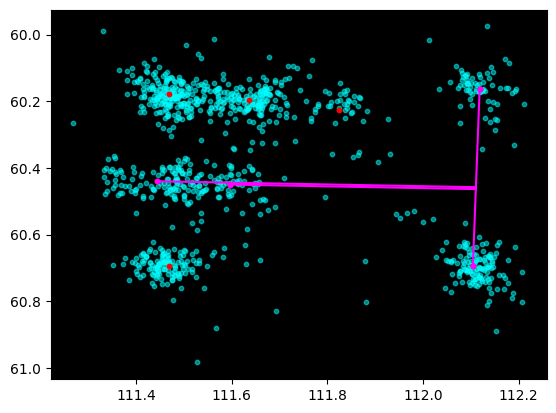

Ratio:
 0.7700805574788557


In [66]:
ratio = process_origami_ratio('data/test_1.hdf5', 8)

In [69]:
def generate_ratio_histogram(ratios, bins=10, title="Histogram of Ratios", xlabel="Ratio", ylabel="Frequency"):
    """
    Generates a histogram of the provided ratios.
    
    :param ratios: List of ratio values to plot.
    :param bins: Number of bins for the histogram.
    :param title: Title of the histogram plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.hist(ratios, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def process_multiple_origami_ratio(filename, k):
    print("Starting process_multiple_origami_ratio")
    
    # Collect data for each group
    group_data_list = collect_group_data(filename, 'locs')
    
    ratios = []  # List to store the ratios for each group
    
    # Process each group
    for group_data in group_data_list:
        group_id = group_data['group']
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        print(f"\nProcessing Group {group_id}")
        print("Data collected:\n", data.head())
        plot_helper(data=data, title=f"Initial Data - Group {group_id}")
        
        labels = find_clusters_k_means(data, k)
        print("K-Means labels:\n", labels)
        plot_helper(data=data, labels=labels, title=f"K-Means Clustering - Group {group_id}")
    
        com = find_com(data, labels)
        print("Centers of Mass (COM):\n", com)
        plot_helper(data=data, labels=labels, com=com, title=f"Centers of Mass - Group {group_id}")
    
        min_bounding_rect = minimum_bounding_rectangle(np.array(com))
        print("Minimum Bounding Rectangle:\n", min_bounding_rect)
        
        closest_side = find_closest_side(np.array(com), min_bounding_rect)
        print("Closest side of bounding rectangle:\n", closest_side)
        
        rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
        print("Rotation angle:\n", rotation_angle)
        
        rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Data:\n", rotated_data[:5])
        
        rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Centers of Mass (COM):\n", rotated_com)
        
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
        
        # Adjust the final orientation if needed
        rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
        if (rotation_angle != final_angle):
            # Rotate the data points by 180 degrees
            rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
        print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
        
        plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Final Adjusted Data and COMs - Group {group_id}")

        second_highest_com = find_middle_left_most_com(rotated_com)
        print("Second Highest COM:\n", second_highest_com)
        
        right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
        print("Right Most COM:\n", right_most_com)
        print("Second Right Most COM:\n", second_right_most_com)
        
        robot_com = find_robot(rotated_com)
        print("Robot COM:\n", robot_com)
    
        ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
        print("Ratio:\n", ratio)
        
        ratios.append(ratio)  # Store the ratio for this group
    
    generate_ratio_histogram(ratios)  # Generate the histogram of all the collected ratios
    
    return ratios


Starting process_multiple_origami_ratio

Processing Group 0
Data collected:
            x         y
0  42.897629  5.893465
1  42.816818  5.834262
2  42.830162  5.812670
3  42.875660  5.817399
4  42.836132  5.822851


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


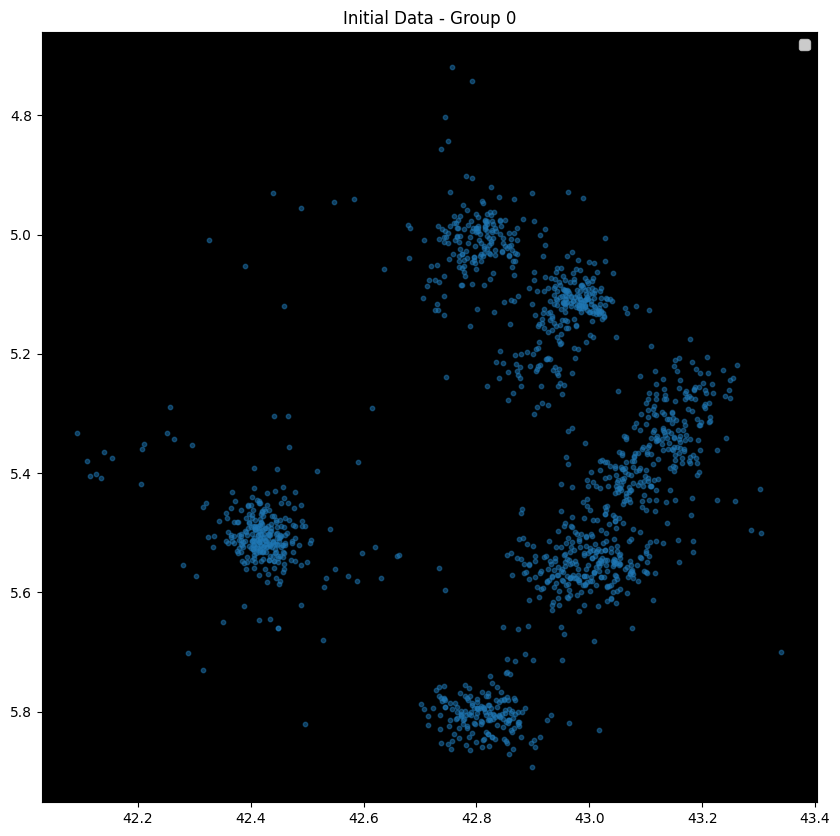

K-Means labels:
 [2 2 2 ... 1 2 0]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


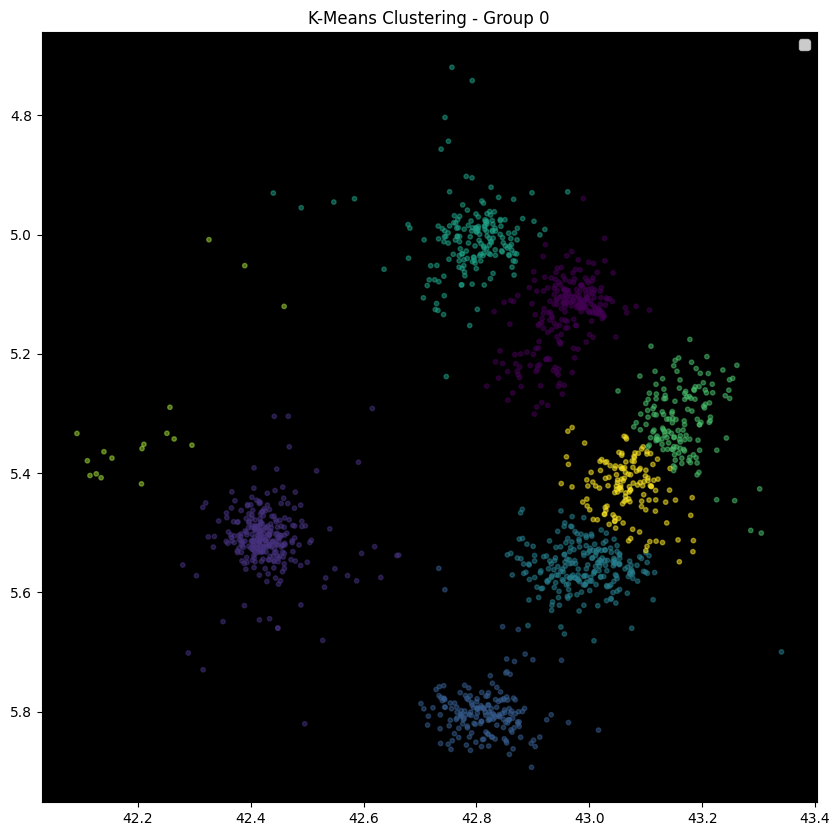

Centers of Mass (COM):
 [(np.float64(42.959169372310484), np.float64(5.132997377132012)), (np.float64(42.428676454824355), np.float64(5.510897815868419)), (np.float64(42.8155654092853), np.float64(5.799916152204021)), (np.float64(42.990956640651085), np.float64(5.558888551516411)), (np.float64(42.7921301559363), np.float64(5.007392254621623)), (np.float64(43.16330390930176), np.float64(5.311256036758423)), (np.float64(42.21997384464039), np.float64(5.311504700604607)), (np.float64(43.06698740965931), np.float64(5.424973687381609))]


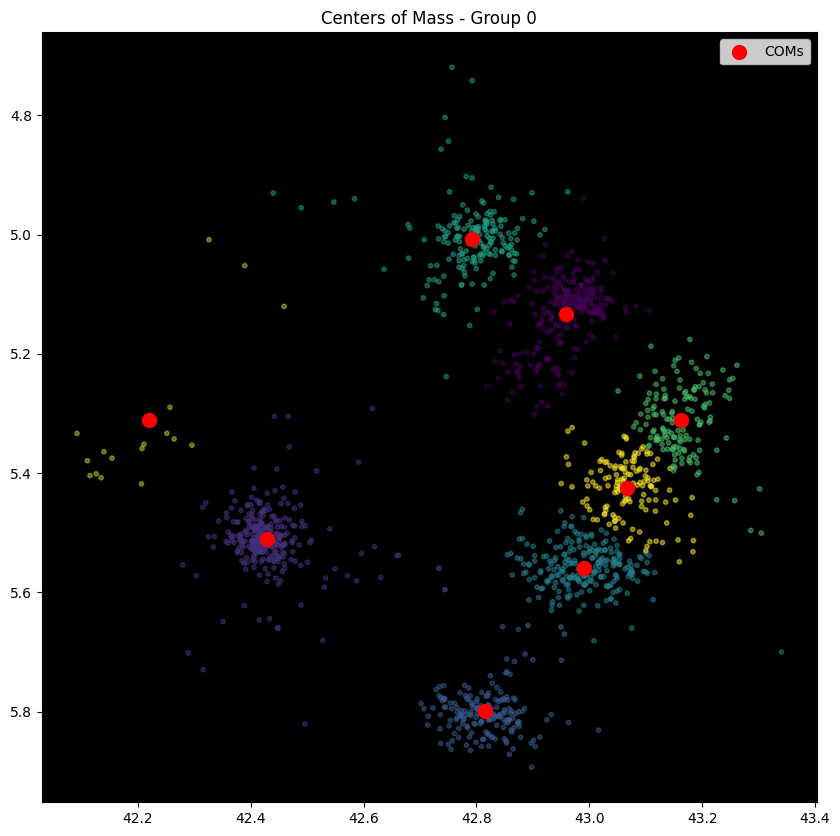

Minimum Bounding Rectangle:
 [[43.18715806  5.30249065]
 [42.5707167   4.84198937]
 [42.19912405  5.33941488]
 [42.81556541  5.79991615]]
Closest side of bounding rectangle:
 3
Closest line start: [42.81556541  5.79991615], end: [43.18715806  5.30249065]
Initial calculated angle: -0.9291976001362098 radians (-53.23910082148951 degrees)
Final rotation angle: 0.9291976001362098 radians (53.23910082148951 degrees)
Rotation angle:
 0.9291976001362098
Rotated Data:
 [[42.7897327   5.92164726]
 [42.78879907  5.82147527]
 [42.81408336  5.81924313]
 [42.83752438  5.85852338]
 [42.80950028  5.83011871]]
Rotated Centers of Mass (COM):
 [[43.43580437  5.51582747]
 [42.81556541  5.31699311]
 [42.81556541  5.79991615]
 [43.11362988  5.7961796 ]
 [43.43646253  5.3068339 ]
 [43.41516406  5.78605152]
 [42.85040349  5.03046091]
 [43.2664171   5.77694592]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.070790253726003 radians (233.2391008214895 degrees)


/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


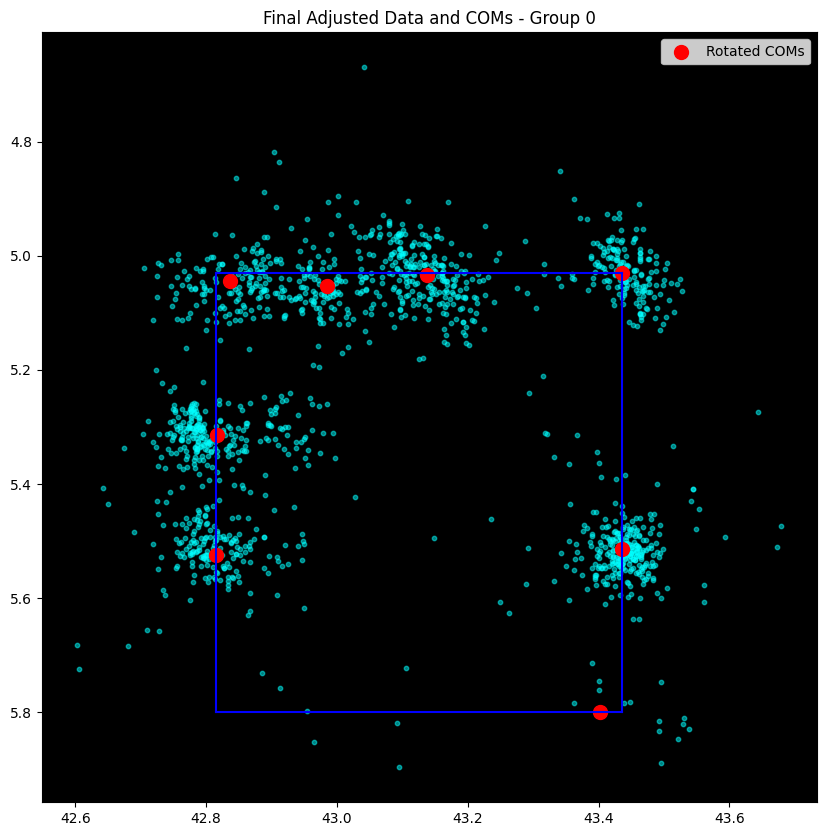

Second Highest COM:
 [42.81622356  5.31454959]
Right Most COM:
 [43.43646253  5.51338395]
Second Right Most COM:
 [43.43646253  5.03046091]
Robot COM:
 [43.13839806  5.03419746]


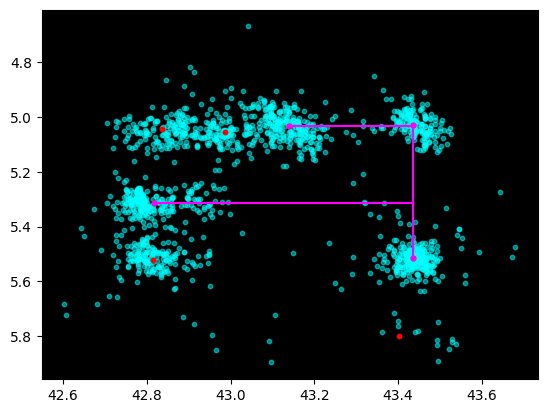

Ratio:
 0.4805639178333244

Processing Group 1
Data collected:
            x         y
0  74.181908  2.675268
1  74.218697  2.590031
2  74.369797  3.188938
3  74.364662  3.175110
4  74.386177  3.169834


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


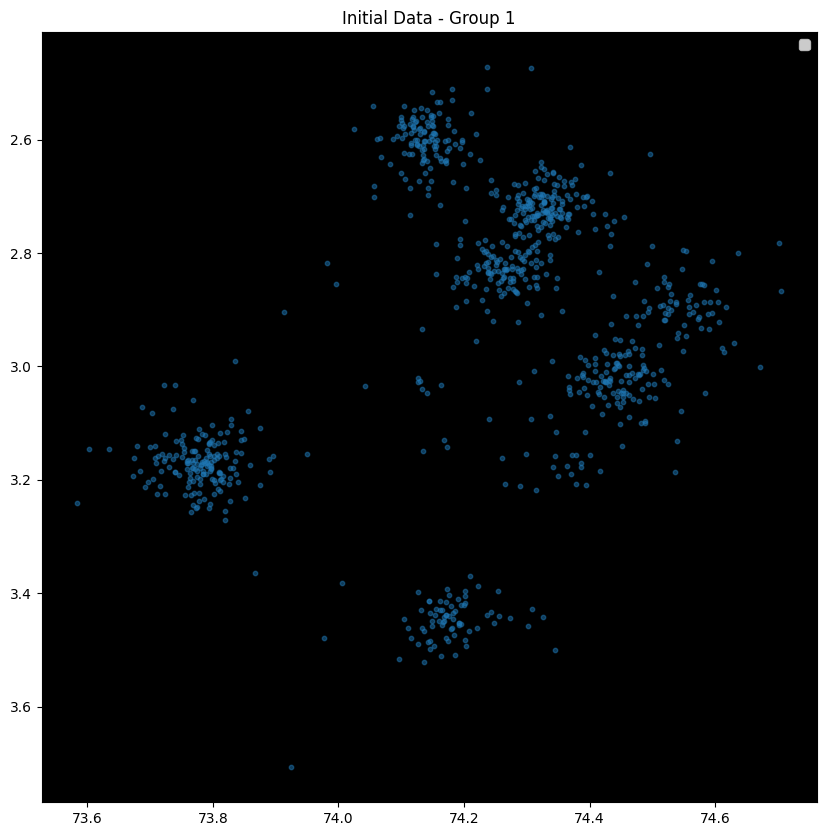

K-Means labels:
 [4 4 0 0 0 0 0 0 0 0 0 6 0 1 1 5 7 7 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 5 5 6 6 6 1 1 1 3 3 3 6 6 6 6 6 6 6 3 3 1 1 1 1 1 1 1 4 4 2 2 4 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 7 7 7 7 6 6 7 7 6 6 2 2 2 2 2 2 2 2 5 5 5 7 5 3 3 3 3 6 6 6 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 3 3 3 3 3 3 3 3 6 6 6 6 3
 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 2 2 2 2 2 2
 2 2 4 4 4 4 4 4 4 6 6 6 6 6 6 6 4 4 4 4 2 2 2 7 2 5 6 3 3 3 3 3 3 3 3 4 4
 5 3 3 3 6 6 6 6 6 6 6 6 6 6 6 6 2 2 3 2 2 3 4 4 5 5 5 5 5 5 2 5 5 5 5 5 5
 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 0 0 0 0 1 5 4 4 4 6 6 6
 6 0 6 6 6 6 4 2 5 5 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 0 2 4 4
 4 4 4 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 5 2 2 5 4 5 7 1 1
 1 1 1 1 1 4 4 4 4 1 1 1 1 1 1 1 4 4 4 4 4 4 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 6 6 0 0 0 2 5 5 4 4 4 4 4 0 1 1 1 1 1 2 2 5 5 5 5 5 5 5 5 5 5
 4 4 2 2

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


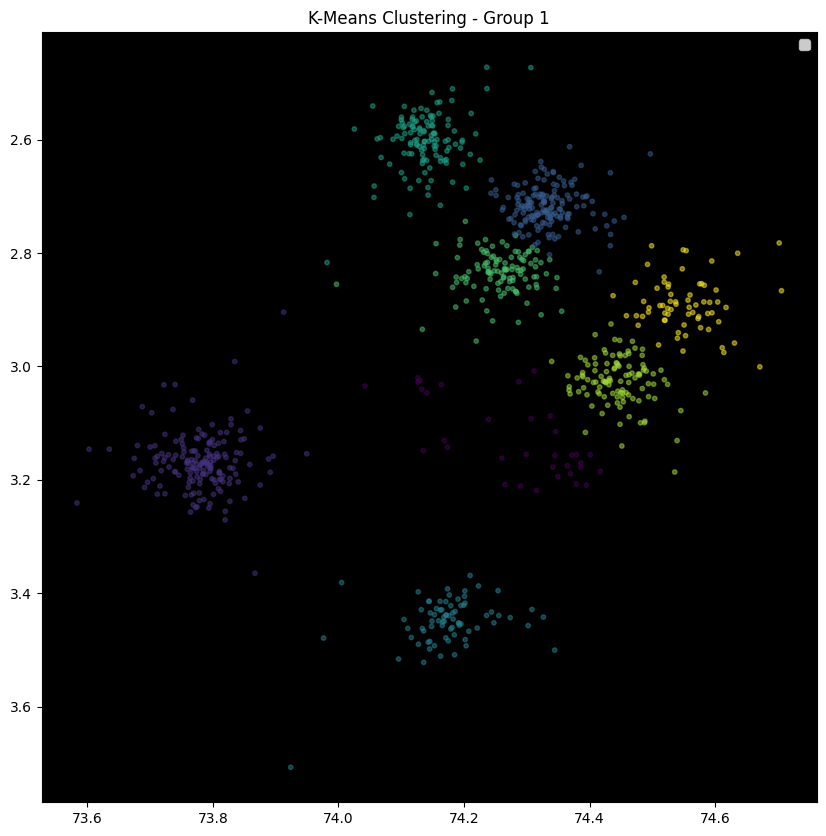

Centers of Mass (COM):
 [(np.float64(74.27897172815659), np.float64(3.127372938043931)), (np.float64(73.77946074708493), np.float64(3.168646534046013)), (np.float64(74.33265622046686), np.float64(2.7179434299468994)), (np.float64(74.17461903889973), np.float64(3.4499339803059894)), (np.float64(74.13930593443311), np.float64(2.602285968370674)), (np.float64(74.25677937000721), np.float64(2.834714855159725)), (np.float64(74.44544079981813), np.float64(3.026104297112981)), (np.float64(74.55210321599787), np.float64(2.89046692125725))]


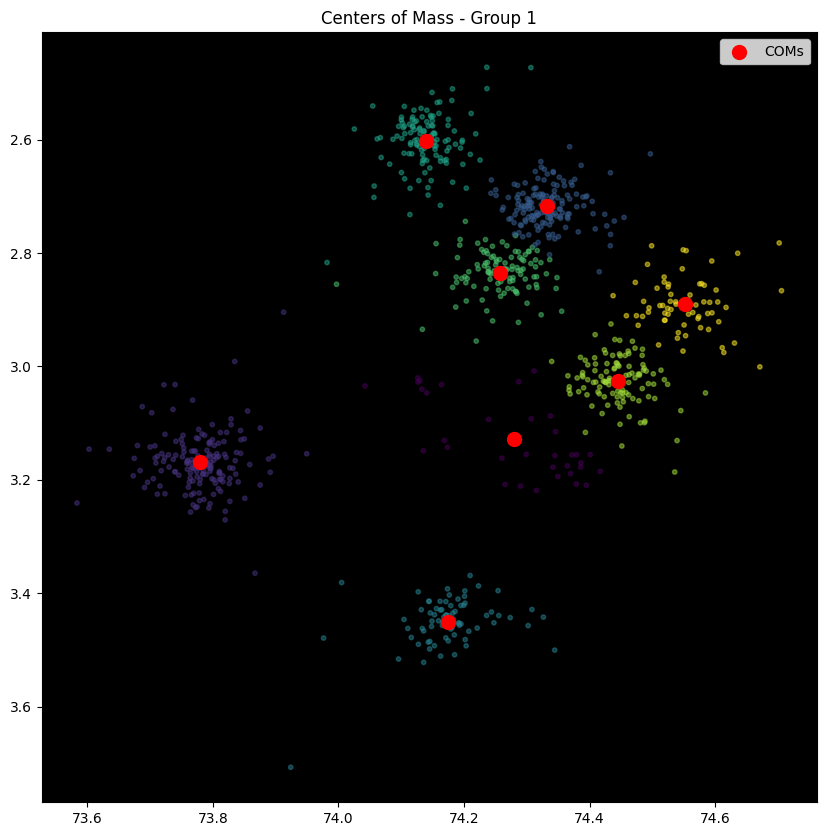

Minimum Bounding Rectangle:
 [[74.56344308  2.87366017]
 [74.14616792  2.59211586]
 [73.75734388  3.16838966]
 [74.17461904  3.44993398]]
Closest side of bounding rectangle:
 3
Closest line start: [74.17461904  3.44993398], end: [74.56344308  2.87366017]
Initial calculated angle: -0.977238350767572 radians (-55.991633077307014 degrees)
Final rotation angle: 0.977238350767572 radians (55.991633077307014 degrees)
Rotation angle:
 0.977238350767572
Rotated Data:
 [[74.82085966  3.02269439]
 [74.91209416  3.0055164 ]
 [74.5001389   3.46574895]
 [74.50872969  3.45375852]
 [74.52513721  3.46864223]]
Rotated Centers of Mass (COM):
 [[74.50037384  3.35602486]
 [74.18677638  2.96503718]
 [74.86979933  3.1715273 ]
 [74.17461904  3.44993398]
 [74.85753075  2.94655961]
 [74.73056199  3.17394063]
 [74.67742955  3.43737942]
 [74.84952473  3.44993398]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.118831004357365 radians (235.99163307730703 degrees)


/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


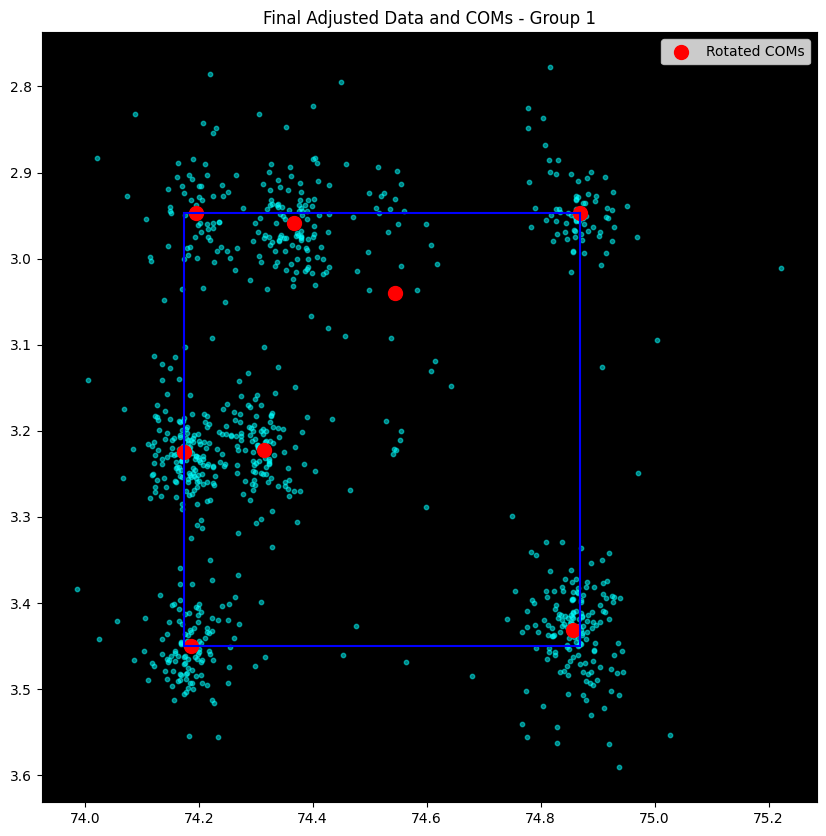

Second Highest COM:
 [74.17461904  3.22496629]
Right Most COM:
 [74.86979933  2.94655961]
Second Right Most COM:
 [74.85764199  3.4314564 ]
Robot COM:
 [74.31385638  3.22255296]


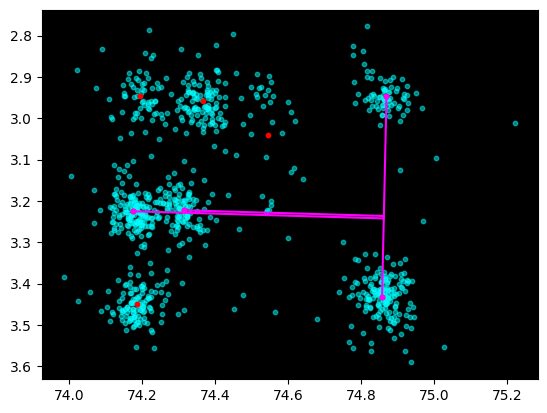

Ratio:
 0.7977668958675053

Processing Group 2
Data collected:
            x          y
0  80.229553  11.981121
1  80.168312  11.962978
2  80.124626  11.972430
3  80.120476  11.994550
4  80.130730  11.978308


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


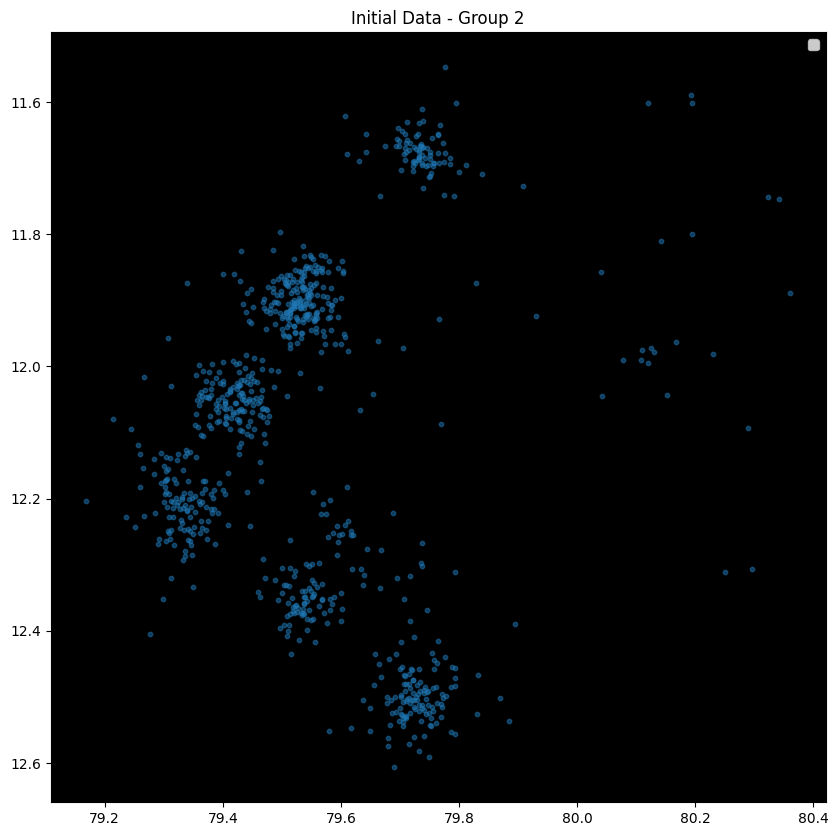

K-Means labels:
 [5 5 5 5 5 1 1 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7 4 4 4 4 3 3
 3 3 3 3 3 3 3 3 3 6 3 5 6 1 1 1 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 1 1 1 7 0 0 0 0 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 4 4 4 6 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 5 5 3 2 2
 2 2 2 1 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 6 4 4 4 4 4 4 4 0 0 0 7 1 3 3 3 3 3 4 0 0 2 2 2 2 2 2 2 2 7 7 4 4 0
 3 3 3 3 3 3 0 6 6 2 2 0 0 0 0 4 4 4 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 4 4 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 2 2 7 6
 2 6 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 5 5 2 3 3 3 6 0
 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 5 7 1 1 1 1 1 1 1 1 1 1 1 6 6 6 4 4 1 4
 4 4 6 6 6 6 6 6 6 6 6 2 2 0 0 6 6 6 6 0 5 5 7 0 0 6 6 6 6 4 4 4 4 6 4 4 2
 2 2 2 2

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


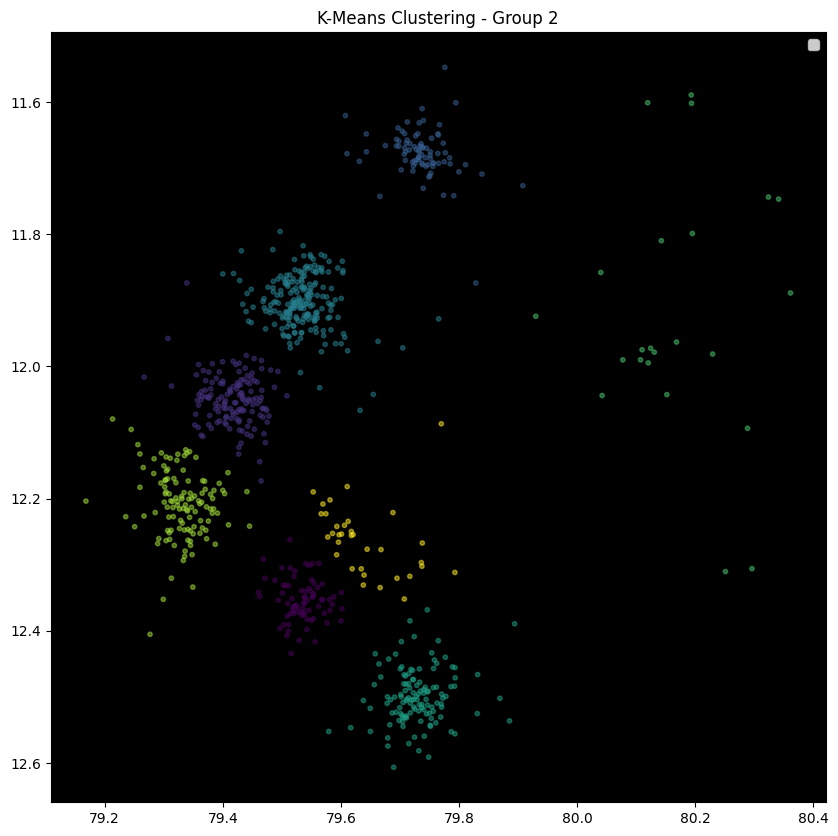

Centers of Mass (COM):
 [(np.float64(79.53449349654348), np.float64(12.354004257603696)), (np.float64(79.41719585445756), np.float64(12.050053156859486)), (np.float64(79.73547944568452), np.float64(11.677294004531134)), (np.float64(79.53313579830512), np.float64(11.902821242526809)), (np.float64(79.72918319702148), np.float64(12.499668637260061)), (np.float64(80.17131506878397), np.float64(11.921803806139076)), (np.float64(79.33030194194377), np.float64(12.20881382757876)), (np.float64(79.64012572344612), np.float64(12.261649047627168))]


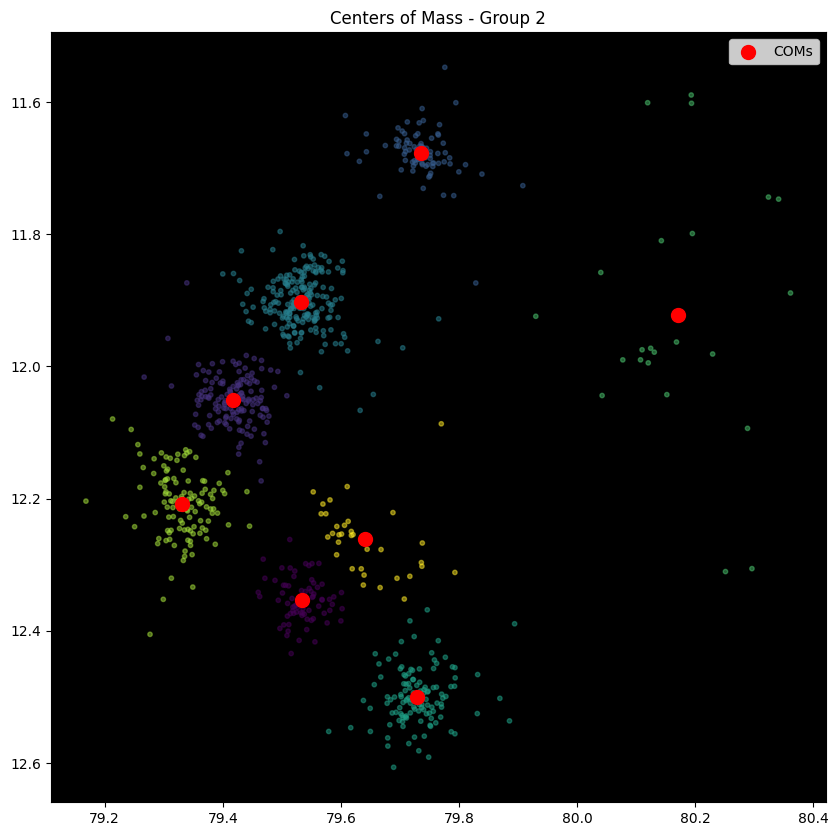

Minimum Bounding Rectangle:
 [[80.17131507 11.92180381]
 [79.74002725 11.60731889]
 [79.31145317 12.19506975]
 [79.742741   12.50955466]]
Closest side of bounding rectangle:
 1
Closest line start: [79.74002725 11.60731889], end: [79.31145317 12.19506975]
Initial calculated angle: 2.2008366107386013 radians (126.09864919319828 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.342429264328395 radians (306.0986491931983 degrees)
Final rotation angle: -5.342429264328395 radians (-306.0986491931983 degrees)
Rotation angle:
 -5.342429264328395
Rotated Data:
 [[79.72641128 12.22309349]
 [79.70498875 12.16292114]
 [79.67161286 12.13319158]
 [79.65129489 12.14287037]
 [79.67045987 12.14158613]]
Rotated Centers of Mass (COM):
 [[79.01560683 11.88117692]
 [79.19209136 11.60731889]
 [79.68080763 11.644872  ]
 [79.37936448 11.6142531 ]
 [79.01261622 12.12430908]
 [79.74002725 12.14108846]
 [79.01261622 11.63064647]
 [79.1524663  11.91211456]]
Final rotation angle after adjustment: -5.3424

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


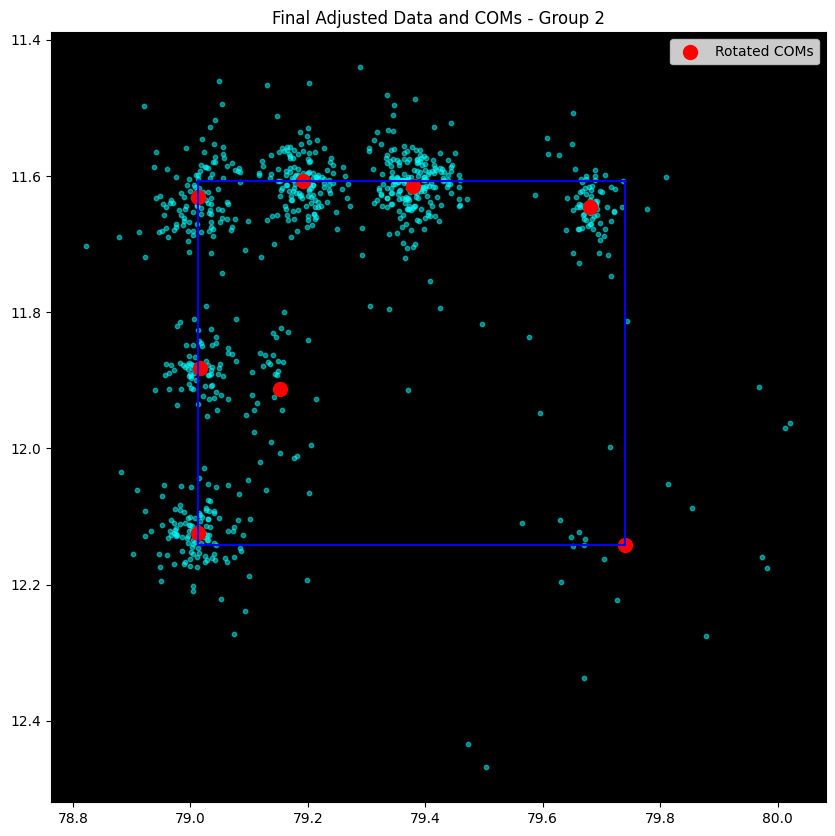

Second Highest COM:
 [79.01560683 11.88117692]
Right Most COM:
 [79.74002725 12.14108846]
Second Right Most COM:
 [79.68080763 11.644872  ]
Robot COM:
 [79.1524663  11.91211456]


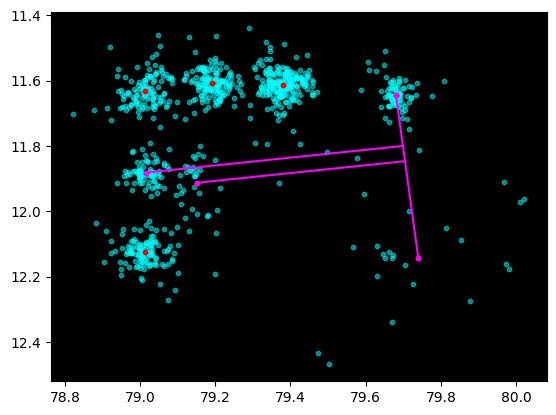

Ratio:
 0.8079507924373667

Processing Group 3
Data collected:
            x         y
0  96.276115  5.262790
1  96.280777  5.182926
2  96.253075  5.196754
3  96.216118  5.205290
4  96.236908  5.174649


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


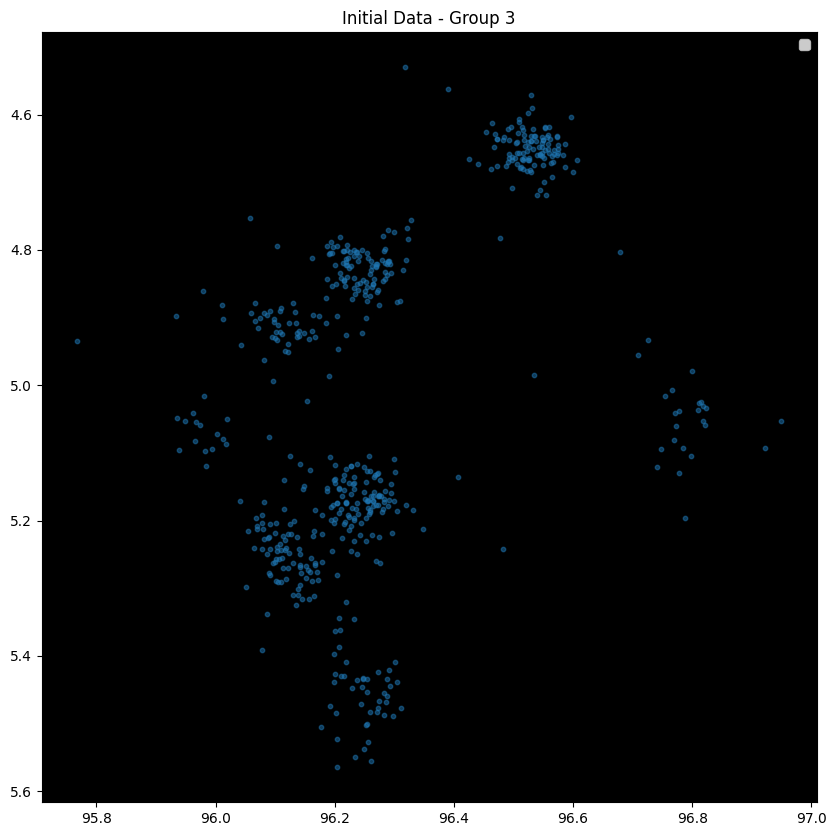

K-Means labels:
 [0 0 0 0 0 2 2 2 2 2 2 2 2 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 1
 1 1 1 1 1 6 6 6 4 4 4 1 1 1 1 5 5 5 5 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 4 4 4 4 4 4 4 4 0 0 1 1 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 6 2 2 2 2 2 2 2
 1 1 2 2 2 2 2 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 5 5
 5 5 5 0 4 4 4 7 7 7 7 0 7 0 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 4 0 4 4 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 4 4 5 5
 5 5 5 6 6 4 0 0 5 4 4 4 0 0 6 6 6 6 4 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 0
 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 2 2 2 2 7 7 7 5 5 5 5 5 4 3 3 3 3 3 3 3
 3 3 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 4 4
 0 4 4 0 0 0 0 7 7 7 4 4 4 0 0 7 0 0 0 3 2 2 2 2 2 2 2 0 3 3 2 2 0 0 6 0 0
 0 0 3 3 3 0 0 0 0 3 3 3 7 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 3 4 4

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


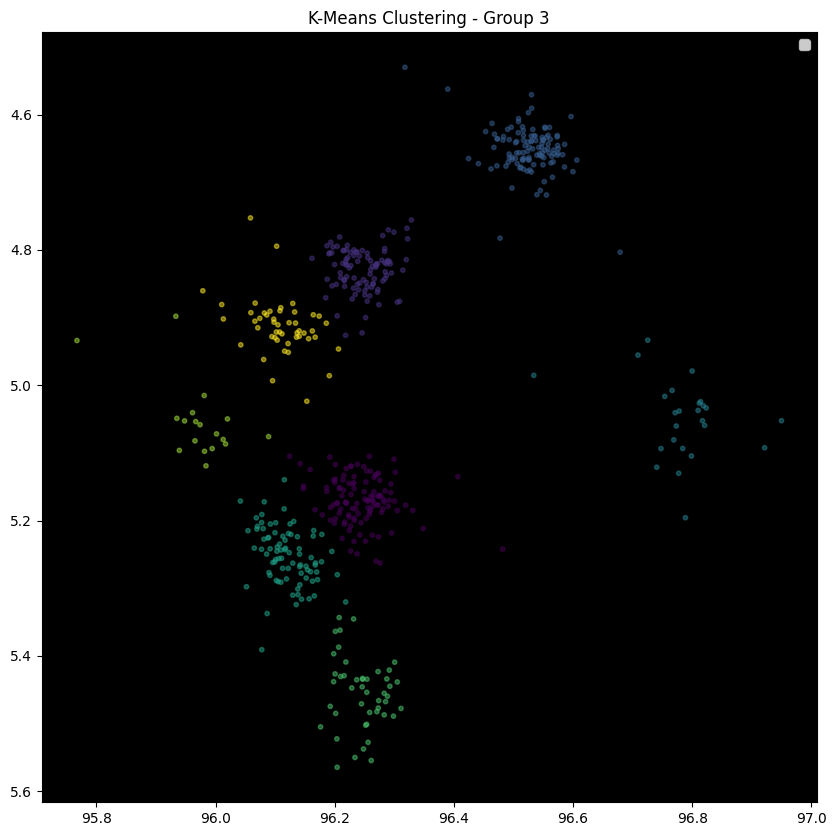

Centers of Mass (COM):
 [(np.float64(96.24395824300832), np.float64(5.169995365471675)), (np.float64(96.2470948961046), np.float64(4.829189396867848)), (np.float64(96.52659242343059), np.float64(4.651792268837448)), (np.float64(96.78432647705078), np.float64(5.049751472473145)), (np.float64(96.12027545091583), np.float64(5.252703178219679)), (np.float64(96.24598710433297), np.float64(5.454964492631995)), (np.float64(95.97059546576605), np.float64(5.053029855092366)), (np.float64(96.10949961344402), np.float64(4.912443409363429))]


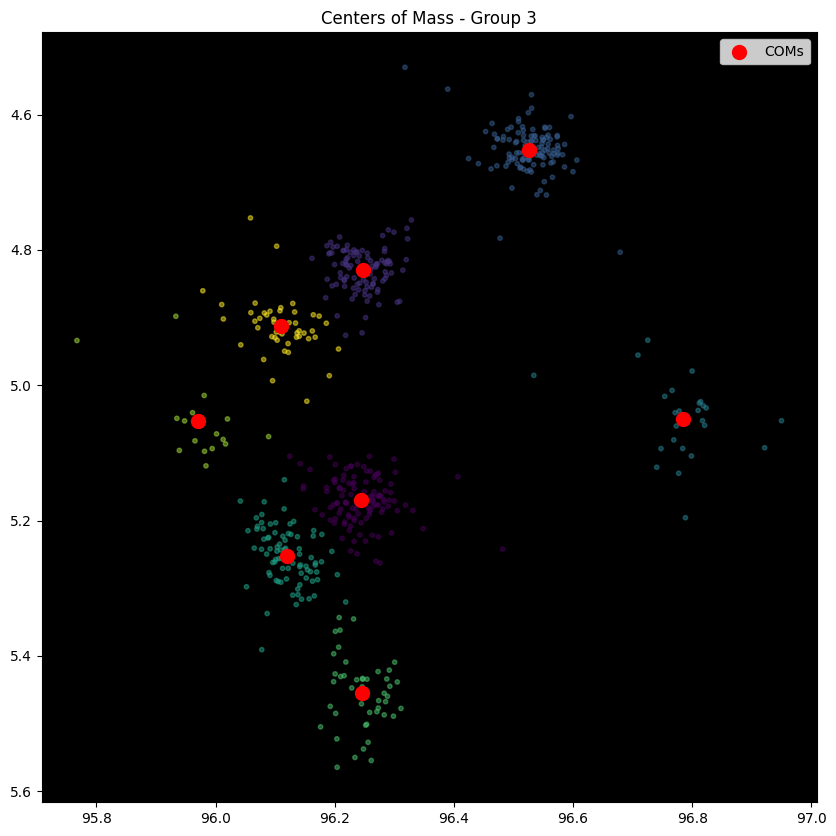

Minimum Bounding Rectangle:
 [[96.81144371  5.06753329]
 [96.51487669  4.63469313]
 [95.94942008  5.02212434]
 [96.2459871   5.45496449]]
Closest side of bounding rectangle:
 1
Closest line start: [96.51487669  4.63469313], end: [95.94942008  5.02212434]
Initial calculated angle: 2.540892449851184 radians (145.582413573129 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.6824851034409765 radians (325.582413573129 degrees)
Final rotation angle: -5.6824851034409765 radians (-325.582413573129 degrees)
Rotation angle:
 -5.6824851034409765
Rotated Data:
 [[95.96289978  5.01788286]
 [96.01188632  4.95463424]
 [95.98121726  4.95038421]
 [95.94590549  4.93653706]
 [95.9803753   4.9230106 ]]
Rotated Centers of Mass (COM):
 [[95.98882156  4.92315679]
 [96.18403954  4.6437852 ]
 [96.51487669  4.65542086]
 [96.50255724  5.12938985]
 [95.84004254  4.92147776]
 [95.82942493  5.15938599]
 [95.82942493  4.67215709]
 [96.02347483  4.63469313]]
Final rotation angle after adjustment: -5.682485

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


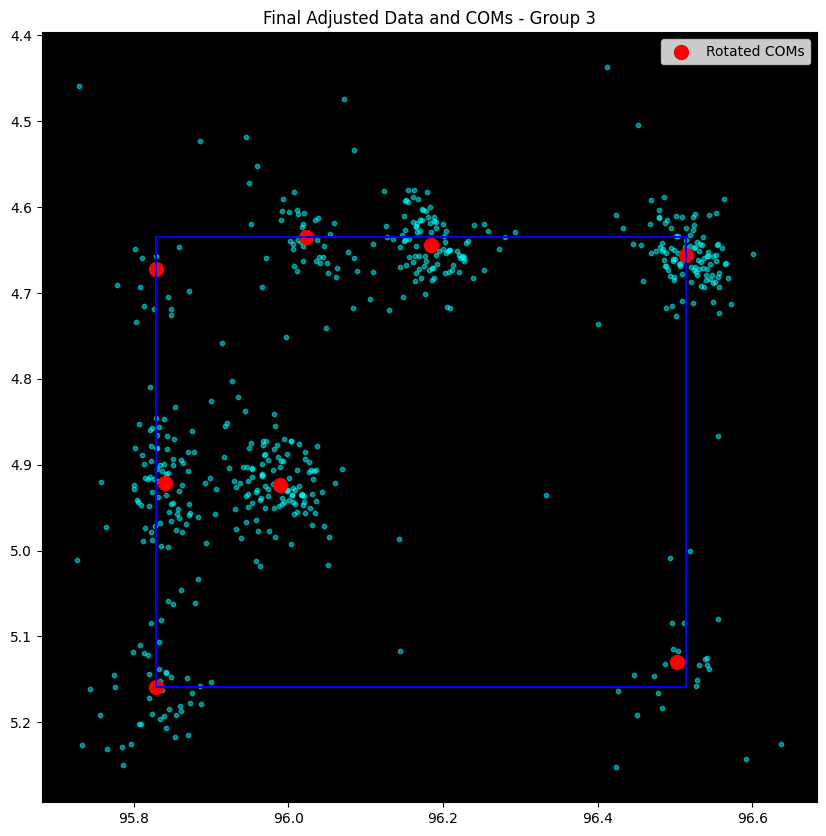

Second Highest COM:
 [95.84004254  4.92147776]
Right Most COM:
 [96.51487669  4.65542086]
Second Right Most COM:
 [96.50255724  5.12938985]
Robot COM:
 [95.98882156  4.92315679]


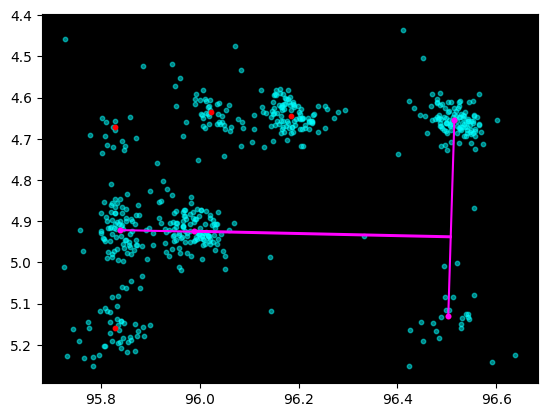

Ratio:
 0.7771844927893748

Processing Group 4
Data collected:
             x          y
0  154.937286  12.149701
1  154.065964  12.067630
2  154.442245  12.426337
3  154.473663  12.418509
4  154.446823  12.387403


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


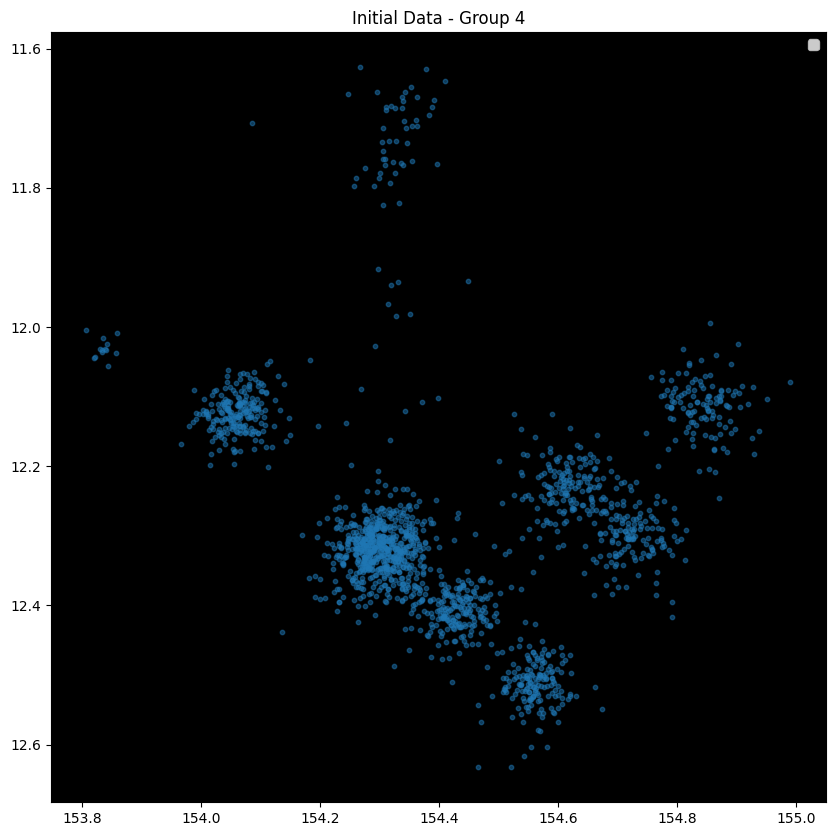

K-Means labels:
 [0 2 6 ... 7 7 7]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


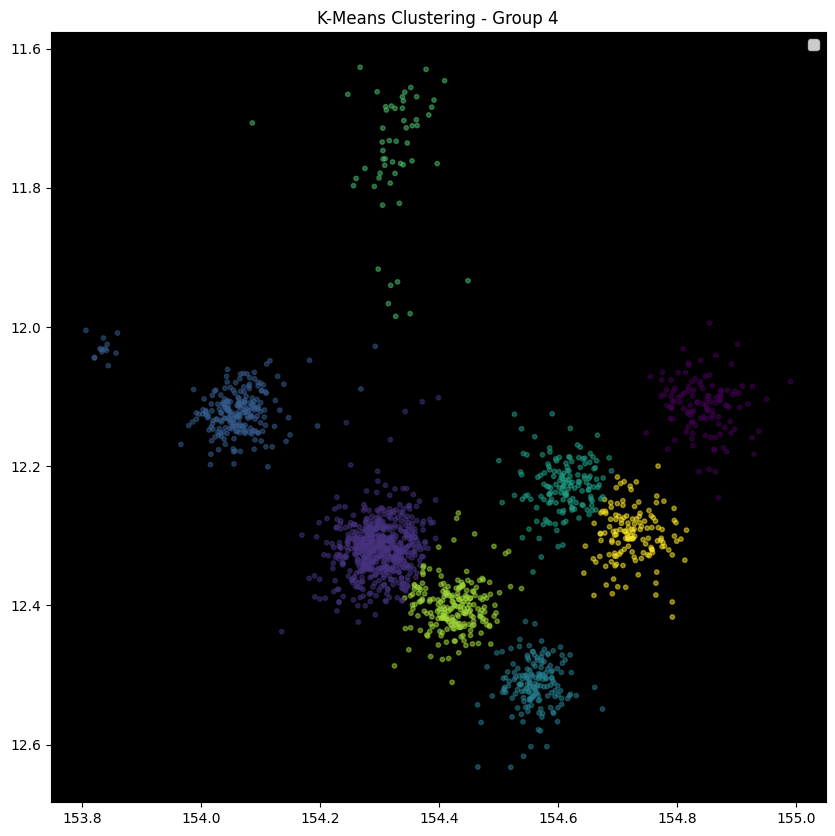

Centers of Mass (COM):
 [(np.float64(154.84418657791517), np.float64(12.113616872424922)), (np.float64(154.29785808378548), np.float64(12.317404563916545)), (np.float64(154.05118603727), np.float64(12.117638014095686)), (np.float64(154.56031336103166), np.float64(12.51306314695449)), (np.float64(154.6097392032021), np.float64(12.228787083374826)), (np.float64(154.32502330433238), np.float64(11.752556471391157)), (np.float64(154.42449521151457), np.float64(12.401920357617465)), (np.float64(154.72505798339844), np.float64(12.299547467912946))]


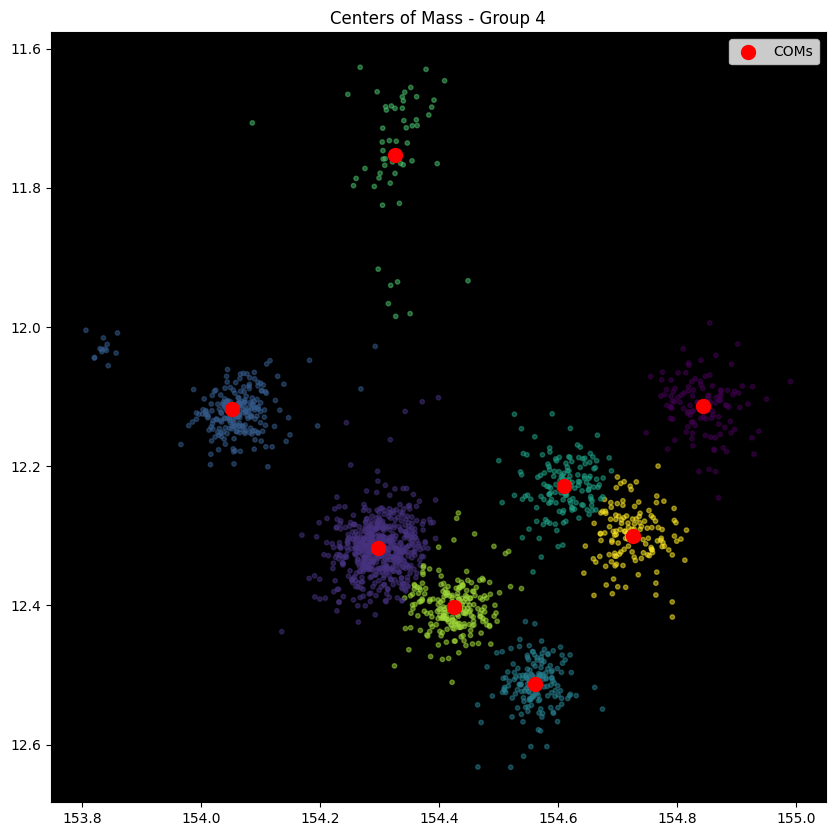

Minimum Bounding Rectangle:
 [[154.85670867  12.12295201]
 [154.33639433  11.73506128]
 [154.04357937  12.12784155]
 [154.56389371  12.51573228]]
Closest side of bounding rectangle:
 2
Closest line start: [154.04357937  12.12784155], end: [154.56389371  12.51573228]
Initial calculated angle: 0.6406104101801188 radians (36.704272815465316 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.782203063769912 radians (216.70427281546532 degrees)
Final rotation angle: -3.782203063769912 radians (-216.70427281546532 degrees)
Rotation angle:
 -3.782203063769912
Rotated Data:
 [[153.31400156  12.64447128]
 [154.06162077  12.18949398]
 [153.54554998  12.12680501]
 [153.52504042  12.15185951]
 [153.56515064  12.16075616]]
Rotated Centers of Mass (COM):
 [[153.41020957  12.61775679]
 [153.72641727  12.12784155]
 [154.04357937  12.14056844]
 [153.39905653  12.12784155]
 [153.52933782  12.38529559]
 [154.04223926  12.59693406]
 [153.57437453  12.13577172]
 [153.39459075  12.39748909]]
Final 

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


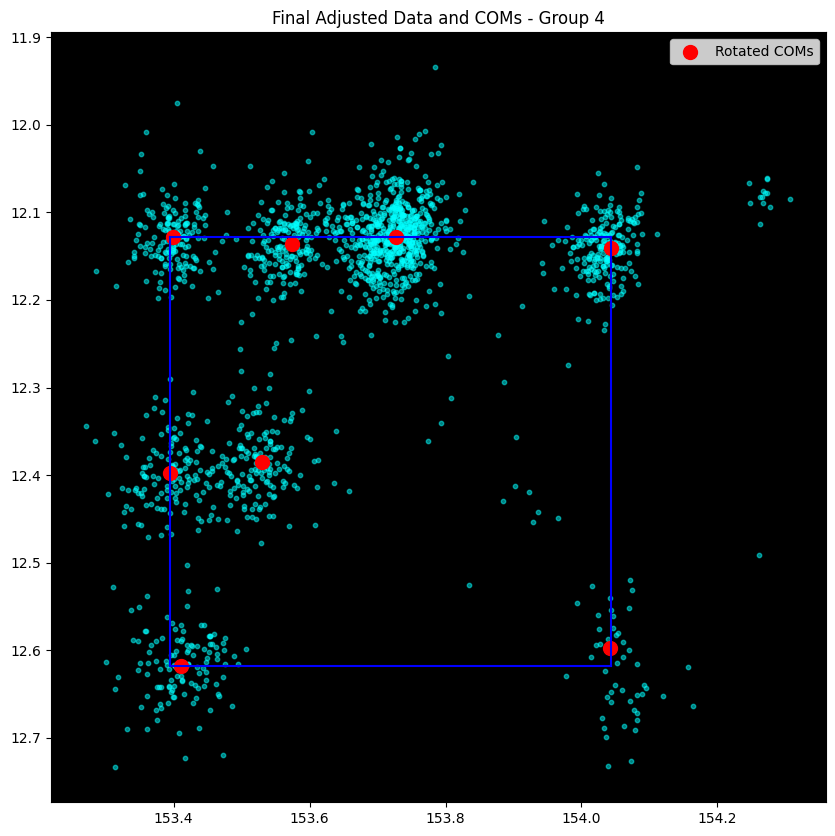

Second Highest COM:
 [153.39459075  12.39748909]
Right Most COM:
 [154.04357937  12.14056844]
Second Right Most COM:
 [154.04223926  12.59693406]
Robot COM:
 [153.52933782  12.38529559]


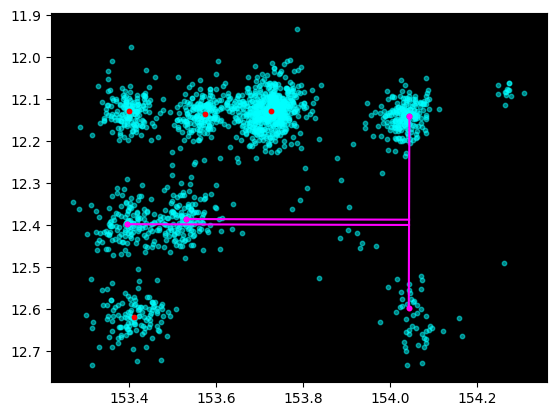

Ratio:
 0.7921873542907827

Processing Group 5
Data collected:
             x          y
0  190.320480  16.102219
1  190.276398  16.173414
2  190.258575  16.114859
3  190.139954  16.050495
4  190.059372  16.388666


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


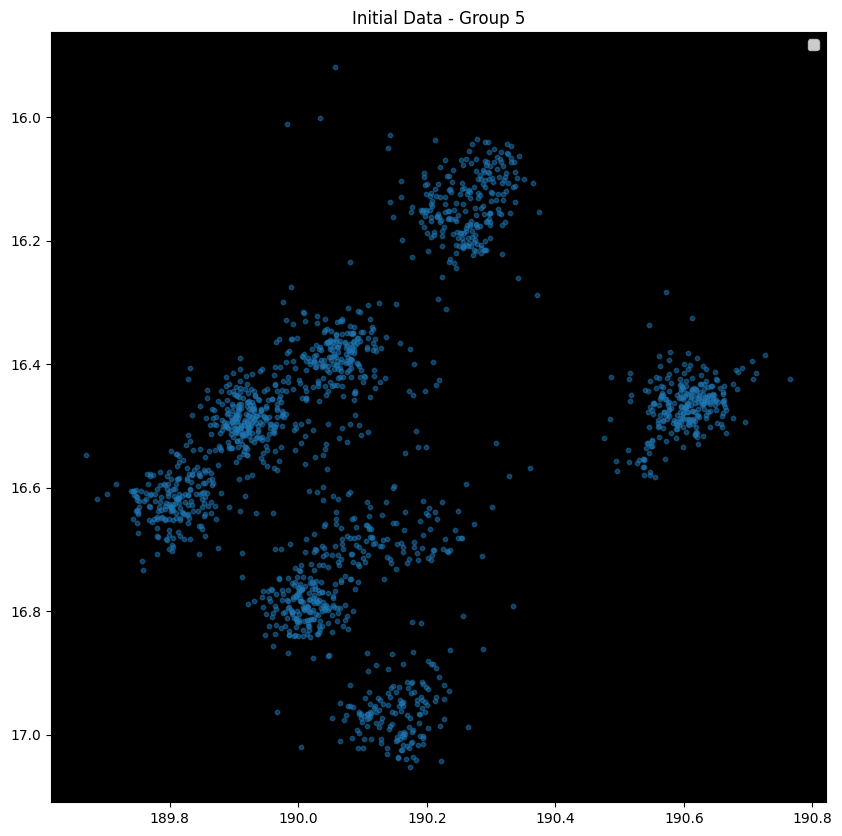

K-Means labels:
 [2 2 2 ... 4 4 4]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


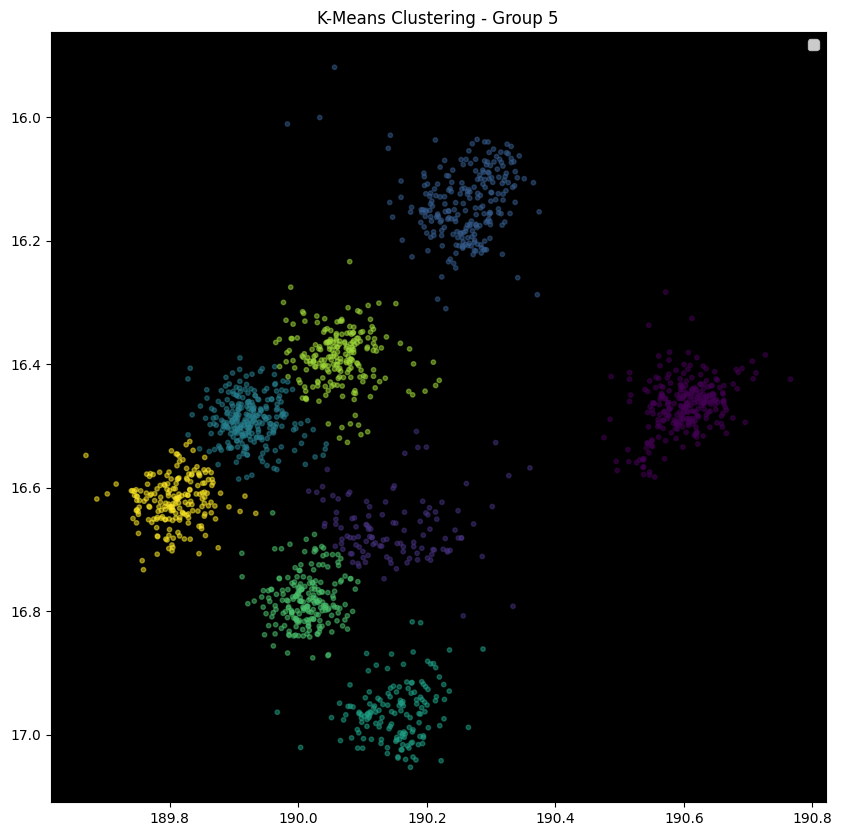

Centers of Mass (COM):
 [(np.float64(190.60105555651356), np.float64(16.46740259645597)), (np.float64(190.14929564386352), np.float64(16.66652112129407)), (np.float64(190.25993032823817), np.float64(16.14046060783157)), (np.float64(189.92427917709924), np.float64(16.489982612150953)), (np.float64(190.1514623245137), np.float64(16.963087056307184)), (np.float64(190.01223790701567), np.float64(16.78151156644866)), (np.float64(190.0642186505762), np.float64(16.389368635496943)), (np.float64(189.808189002835), np.float64(16.620651176997594))]


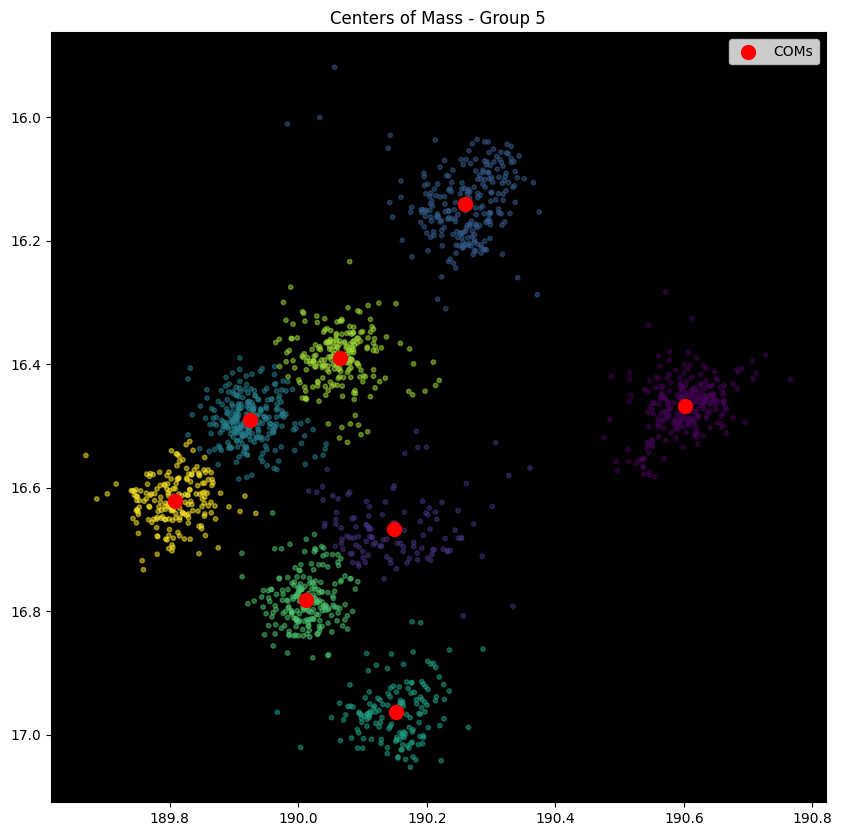

Minimum Bounding Rectangle:
 [[190.61433717  16.48013199]
 [190.25958554  16.14013015]
 [189.79671069  16.62308522]
 [190.15146232  16.96308706]]
Closest side of bounding rectangle:
 1
Closest line start: [190.25958554  16.14013015], end: [189.79671069  16.62308522]
Initial calculated angle: 2.3349674205800315 radians (133.78377849978403 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.476560074169825 radians (313.7837784997841 degrees)
Final rotation angle: -5.476560074169825 radians (-313.7837784997841 degrees)
Rotation angle:
 -5.476560074169825
Rotated Data:
 [[190.32909148  16.15786108]
 [190.24718888  16.17529835]
 [190.27713154  16.12191456]
 [190.24152011  15.99173921]
 [189.94161789  16.16755642]]
Rotated Centers of Mass (COM):
 [[190.25958554  16.61310904]
 [189.80324048  16.42473602]
 [190.25958554  16.14060773]
 [189.77499592  16.14013015]
 [189.59063209  16.63150575]
 [189.62538685  16.4053527 ]
 [189.94446435  16.1715416 ]
 [189.60033165  16.14673279]]
Final ro

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


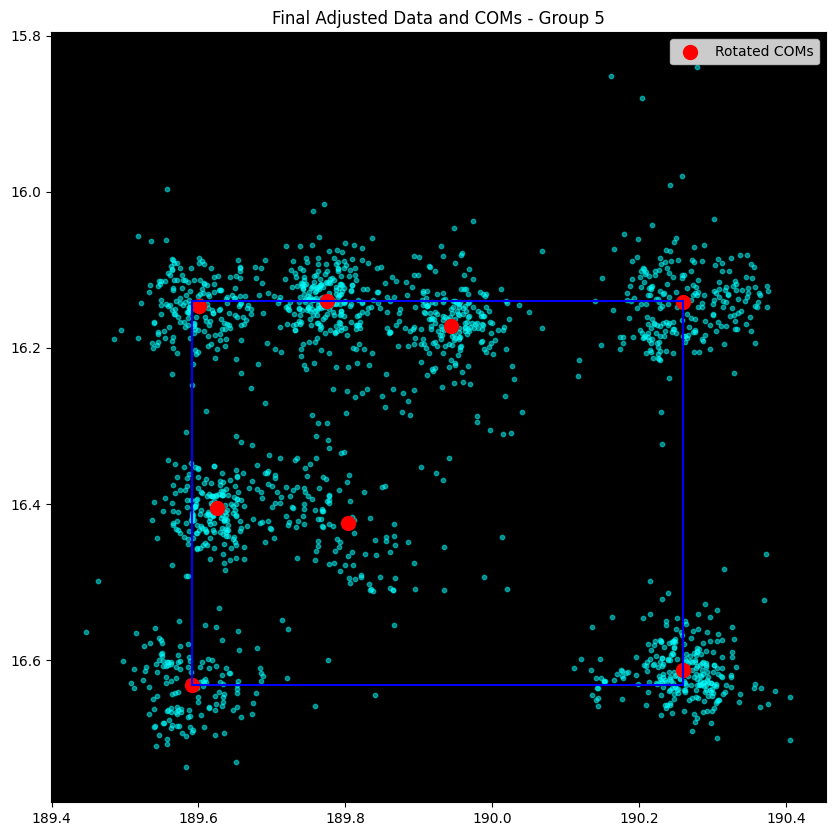

Second Highest COM:
 [189.62538685  16.4053527 ]
Right Most COM:
 [190.25958554  16.61310904]
Second Right Most COM:
 [190.25958554  16.14060773]
Robot COM:
 [189.80324048  16.42473602]


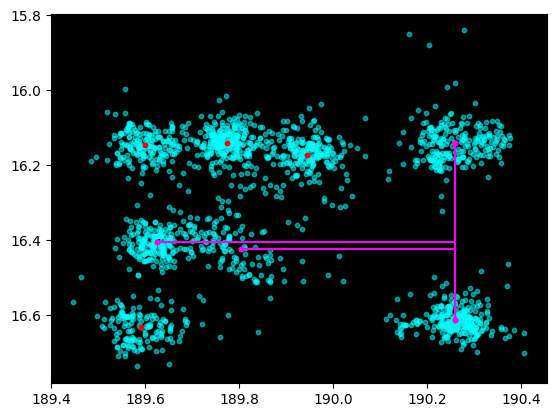

Ratio:
 0.7195616600047895

Processing Group 6
Data collected:
             x         y
0  192.853226  3.511629
1  192.808411  3.494667
2  192.990067  3.477808
3  192.797516  3.549601
4  192.846237  3.472739


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


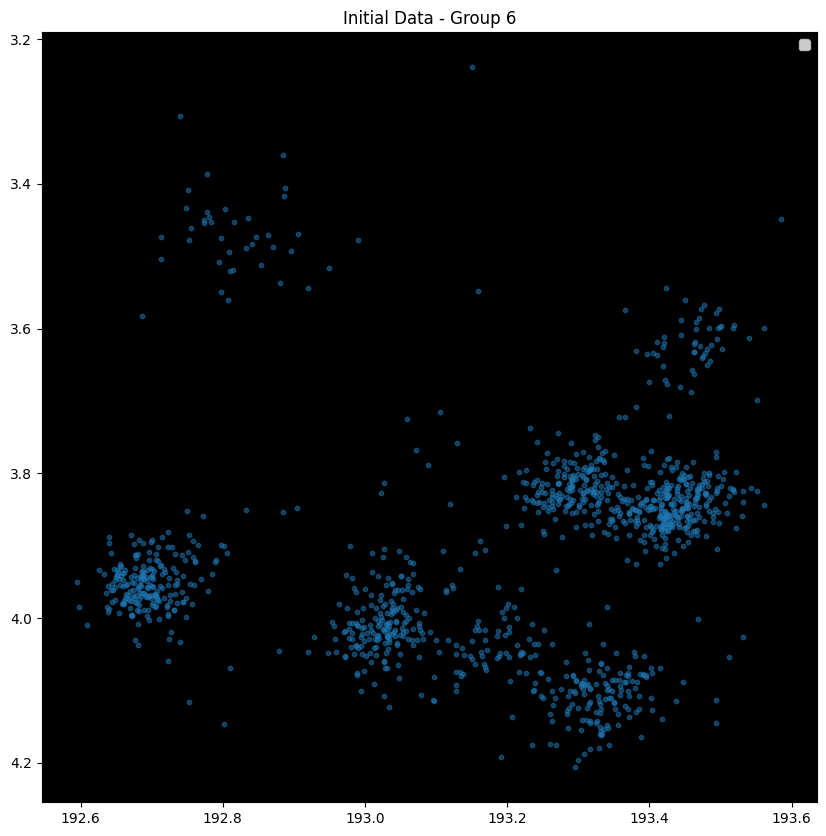

K-Means labels:
 [4 4 4 ... 0 0 6]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


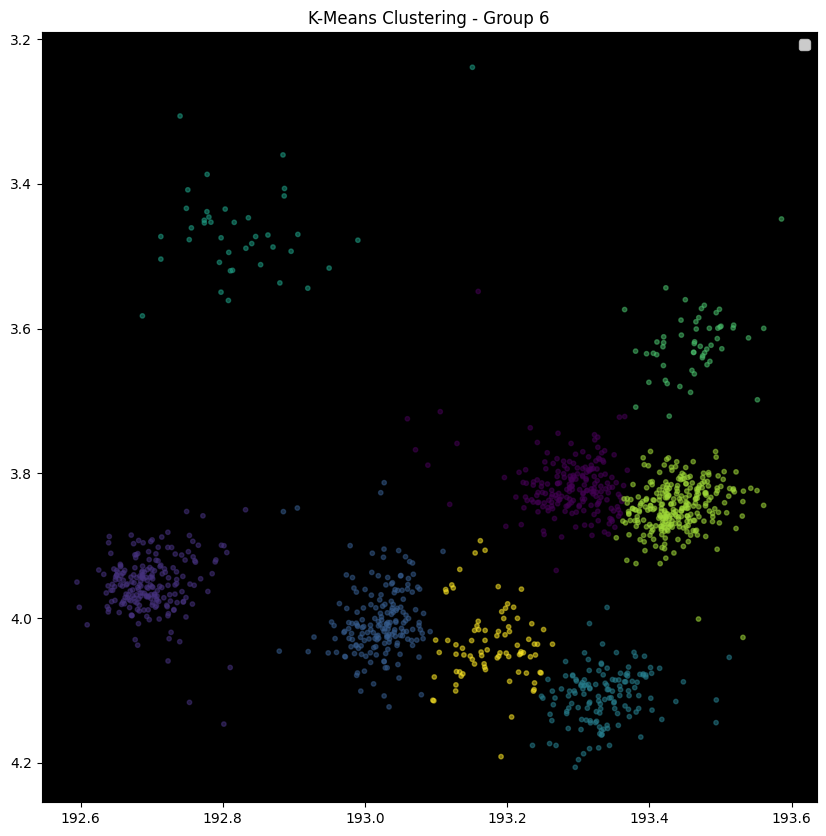

Centers of Mass (COM):
 [(np.float64(193.2893615415947), np.float64(3.8175938009616717)), (np.float64(192.69750955071248), np.float64(3.9537883241411667)), (np.float64(193.02164210535545), np.float64(4.003581663521614)), (np.float64(193.33668298515485), np.float64(4.107724654588768)), (np.float64(192.82681579589843), np.float64(3.46524173617363)), (np.float64(193.4624910707827), np.float64(3.620672071421588)), (np.float64(193.43850013925712), np.float64(3.8464720576248443)), (np.float64(193.17829009633004), np.float64(4.0361552238464355))]


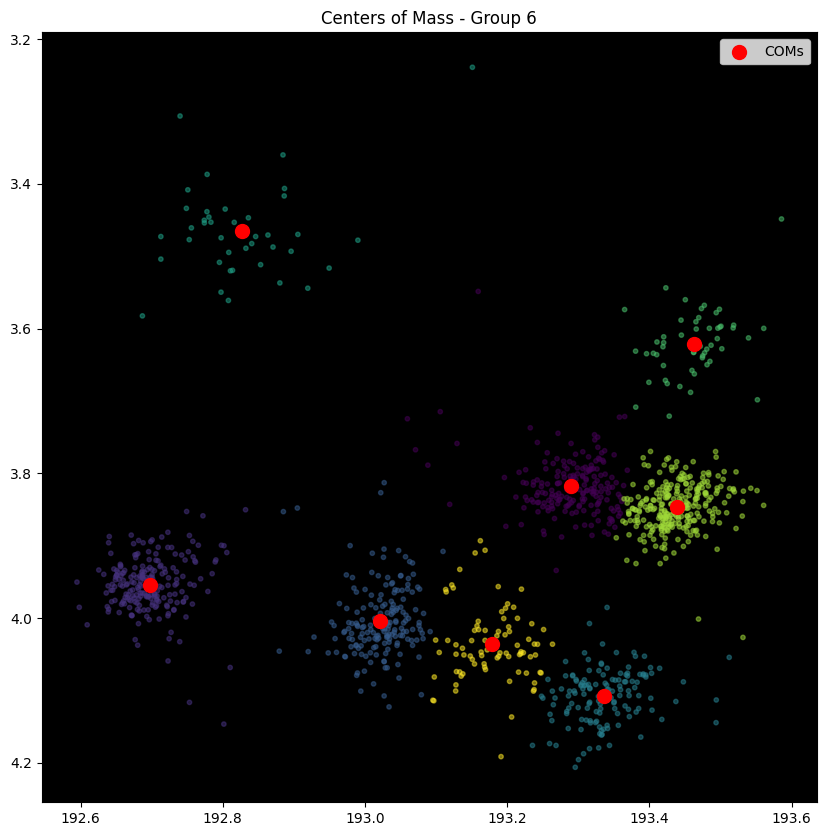

Minimum Bounding Rectangle:
 [[193.49194976   3.62787508]
 [192.81752084   3.46296901]
 [192.69750955   3.95378832]
 [193.37193847   4.1186944 ]]
Closest side of bounding rectangle:
 2
Closest line start: [192.69750955   3.95378832], end: [193.37193847   4.1186944 ]
Initial calculated angle: 0.23980700643578945 radians (13.739929366437305 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.3813996600255827 radians (193.7399293664373 degrees)
Final rotation angle: -3.3813996600255827 radians (-193.7399293664373 degrees)
Rotation angle:
 -3.3813996600255827
Rotated Data:
 [[192.65126885   4.42027936]
 [192.69883028   4.42611199]
 [192.52637686   4.48563417]
 [192.69636563   4.3701623 ]
 [192.6672945    4.45639718]]
Rotated Centers of Mass (COM):
 [[192.15494236   4.2266593 ]
 [192.69750955   3.95378832]
 [192.37082575   3.98240627]
 [192.0400646    3.95607044]
 [192.68794078   4.45906677]
 [192.03353903   4.45906677]
 [192.00321251   4.23403011]
 [192.21092371   3.98797112]]
Fina

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


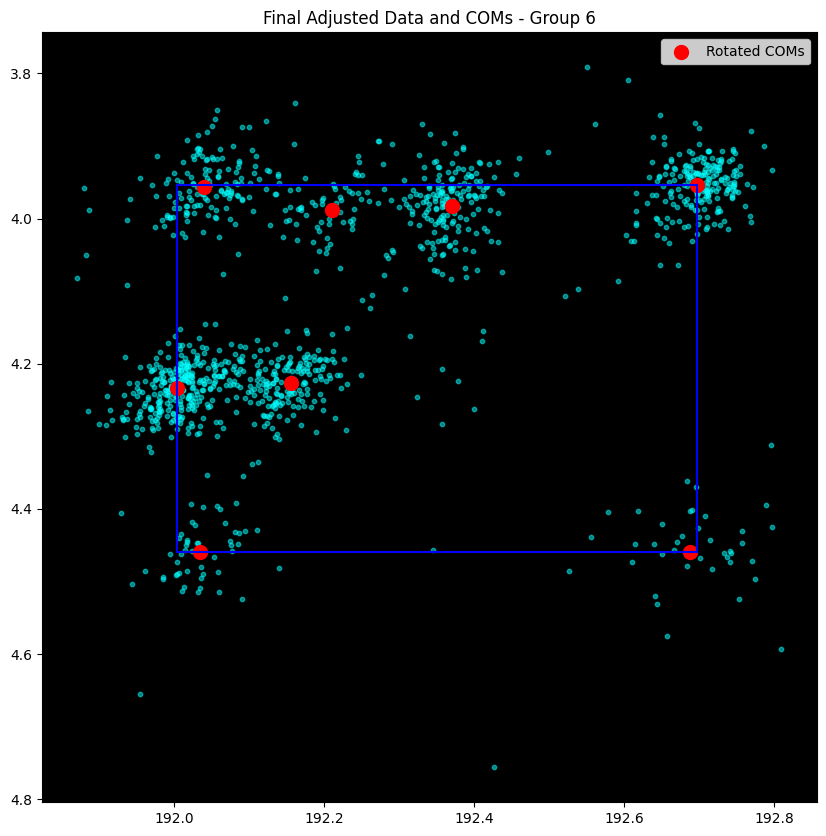

Second Highest COM:
 [192.00321251   4.23403011]
Right Most COM:
 [192.69750955   3.95378832]
Second Right Most COM:
 [192.68794078   4.45906677]
Robot COM:
 [192.15494236   4.2266593 ]


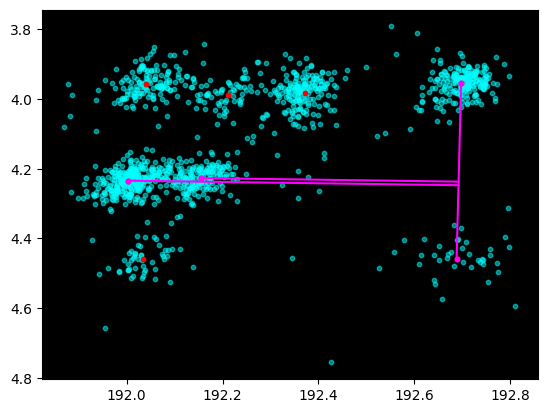

Ratio:
 0.7799818899101107

Processing Group 7
Data collected:
             x          y
0  223.384872  14.570362
1  223.379608  14.605626
2  223.415466  14.562952
3  223.395050  14.599780
4  223.444214  14.630434


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


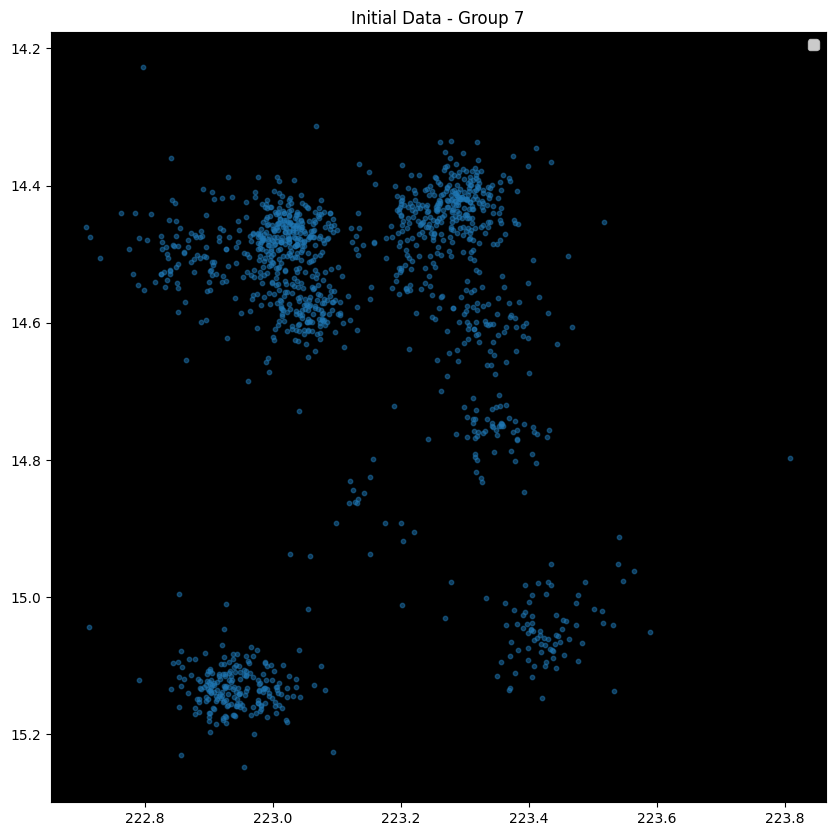

K-Means labels:
 [4 4 4 ... 1 0 6]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


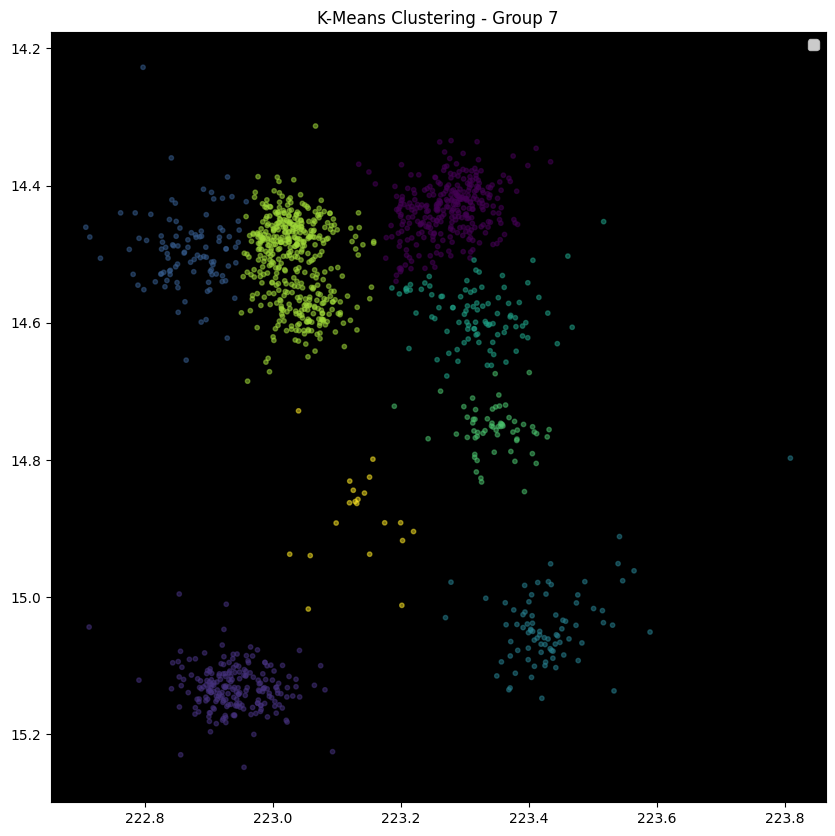

Centers of Mass (COM):
 [(np.float64(223.27507596950593), np.float64(14.433844281193426)), (np.float64(222.93997293625964), np.float64(15.132290315854041)), (np.float64(222.86796373423962), np.float64(14.494447273783164)), (np.float64(223.43251112949702), np.float64(15.04354229679814)), (np.float64(223.31833115444388), np.float64(14.58643986076437)), (np.float64(223.34519658323194), np.float64(14.756138957914759)), (np.float64(223.03403370468706), np.float64(14.50996247044316)), (np.float64(223.1316246032715), np.float64(14.88299789428711))]


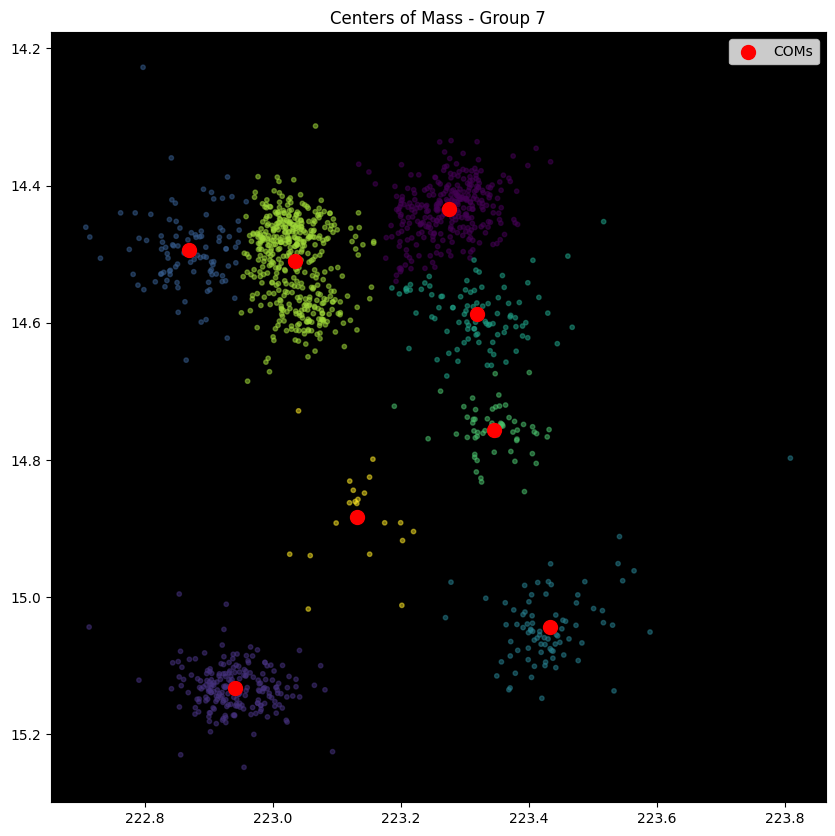

Minimum Bounding Rectangle:
 [[223.43475803  15.05863628]
 [223.34030563  14.42413415]
 [222.84552054  14.49778818]
 [222.93997294  15.13229032]]
Closest side of bounding rectangle:
 0
Closest line start: [223.43475803  15.05863628], end: [223.34030563  14.42413415]
Initial calculated angle: -1.7185718113654778 radians (-98.46691158139492 degrees)
Final rotation angle: 1.7185718113654778 radians (98.46691158139492 degrees)
Rotation angle:
 1.7185718113654778
Rotated Data:
 [[223.92505562  15.08118702]
 [223.89095105  15.0707879 ]
 [223.92788032  15.11253849]
 [223.89445972  15.08692225]
 [223.85690107  15.1310368 ]]
Rotated Centers of Mass (COM):
 [[224.07625177  14.99268786]
 [223.43475803  14.55839913]
 [224.07625177  14.58108964]
 [223.45001834  15.05863628]
 [223.9189505   15.0130037 ]
 [223.74714532  15.01459013]
 [224.03645382  14.74306519]
 [223.65311498  14.78466738]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.860164464955271 radians (278.4669115813949 de

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


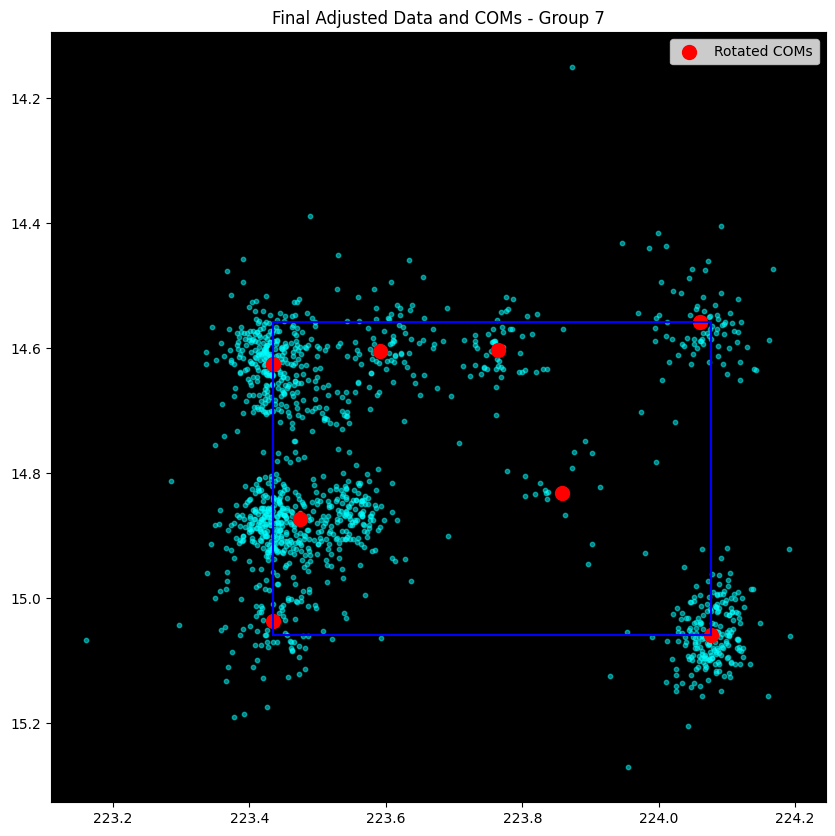

Second Highest COM:
 [223.47455598  14.87397023]
Right Most COM:
 [224.07625177  15.05863628]
Second Right Most COM:
 [224.06099146  14.55839913]
Robot COM:
 [223.85789482  14.83236804]


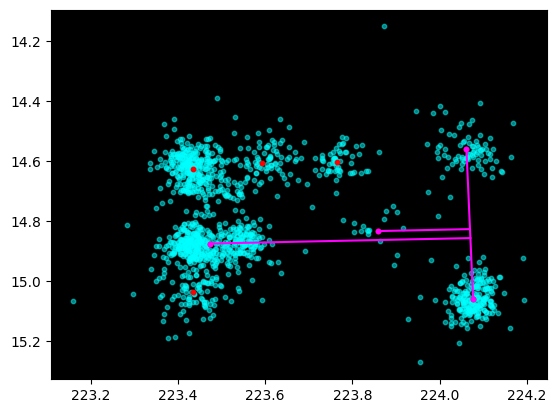

Ratio:
 0.35475211157707565

Processing Group 8
Data collected:
             x         y
0  237.977173  6.251901
1  238.027069  6.185611
2  238.016663  6.100646
3  238.483246  5.802577
4  238.440857  5.771270


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


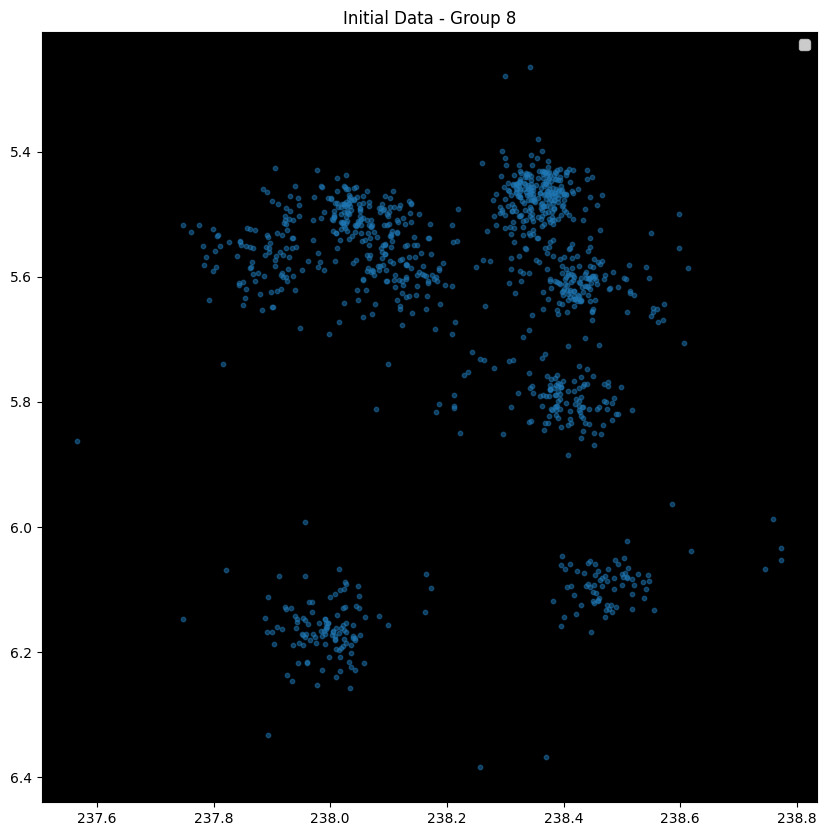

K-Means labels:
 [2 2 2 ... 6 6 6]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


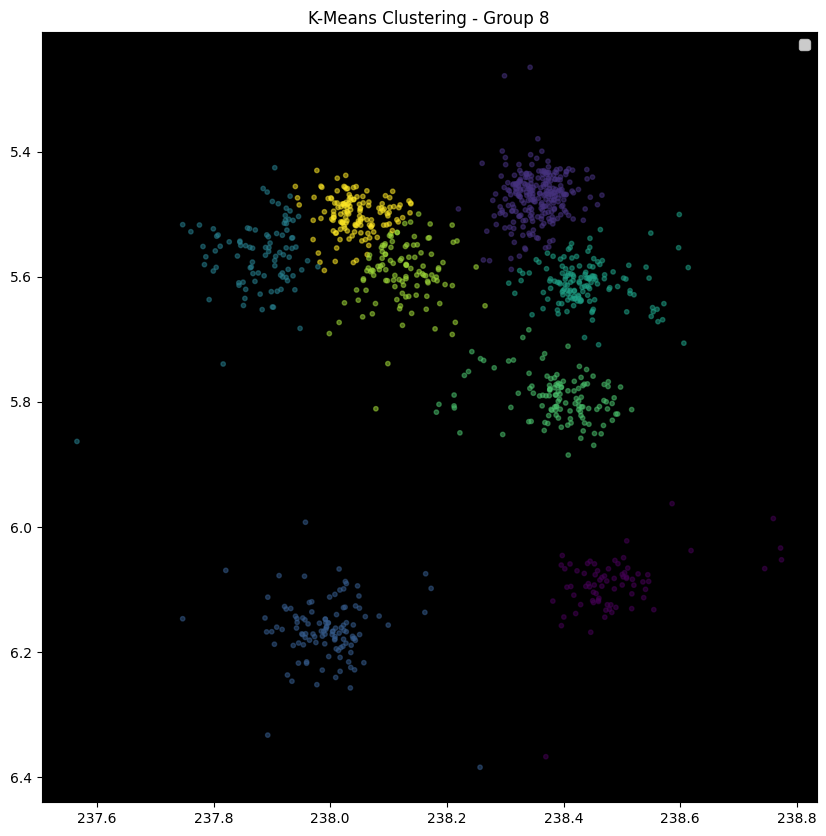

Centers of Mass (COM):
 [(np.float64(238.48725077311198), np.float64(6.092408180236816)), (np.float64(238.35425926831908), np.float64(5.4715285802165825)), (np.float64(237.99338153341543), np.float64(6.164132669697637)), (np.float64(237.87888842130963), np.float64(5.566739684657047)), (np.float64(238.4365927956321), np.float64(5.611138427174175)), (np.float64(238.3882244519951), np.float64(5.793326519737559)), (np.float64(238.12560163225447), np.float64(5.594851306506565)), (np.float64(238.04266151806988), np.float64(5.5008632105293005))]


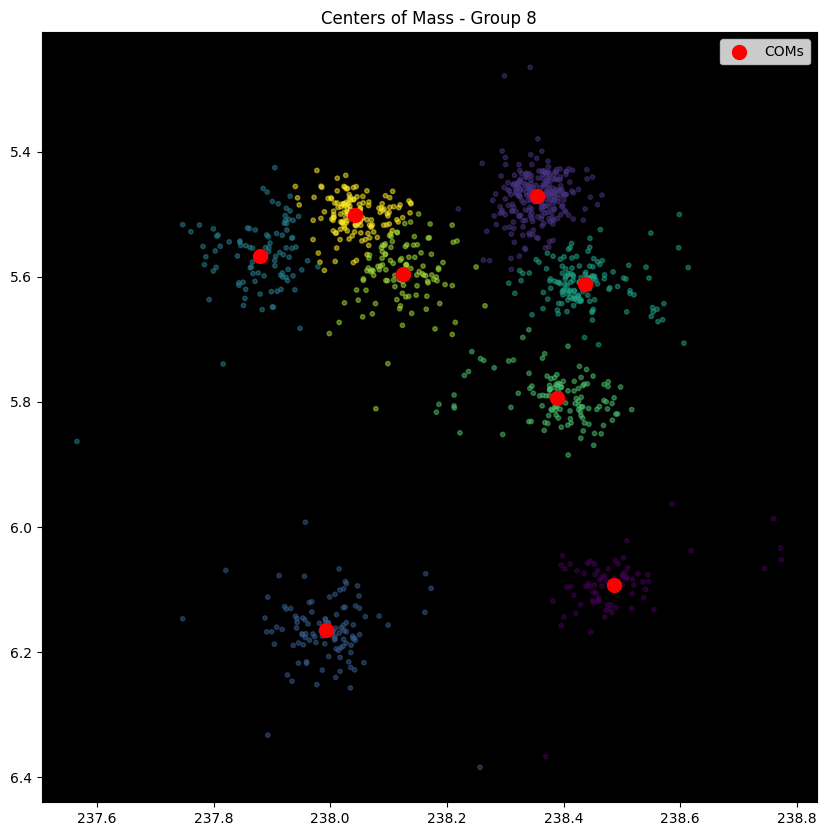

Minimum Bounding Rectangle:
 [[238.52735719   6.0847216 ]
 [238.40224983   5.43194646]
 [237.87251271   5.53347301]
 [237.99762007   6.18624816]]
Closest side of bounding rectangle:
 0
Closest line start: [238.52735719   6.0847216 ], end: [238.40224983   5.43194646]
Initial calculated angle: -1.760154735255414 radians (-100.849437620102 degrees)
Final rotation angle: 1.760154735255414 radians (100.849437620102 degrees)
Rotation angle:
 1.760154735255414
Rotated Data:
 [[238.46672695   5.51290378]
 [238.52244003   5.5743858 ]
 [238.60784532   5.58015823]
 [238.81276105   6.09450639]
 [238.85148748   6.05876809]]
Rotated Centers of Mass (COM):
 [[238.52735719   6.04388524]
 [239.16217152   6.03013836]
 [238.54987518   5.5453432 ]
 [239.15814079   5.5453432 ]
 [239.00955963   6.0847216 ]
 [238.83973243   6.00292478]
 [239.08409312   5.78235505]
 [239.19201292   5.71858874]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.901747388845207 radians (280.849437620102 degrees)

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


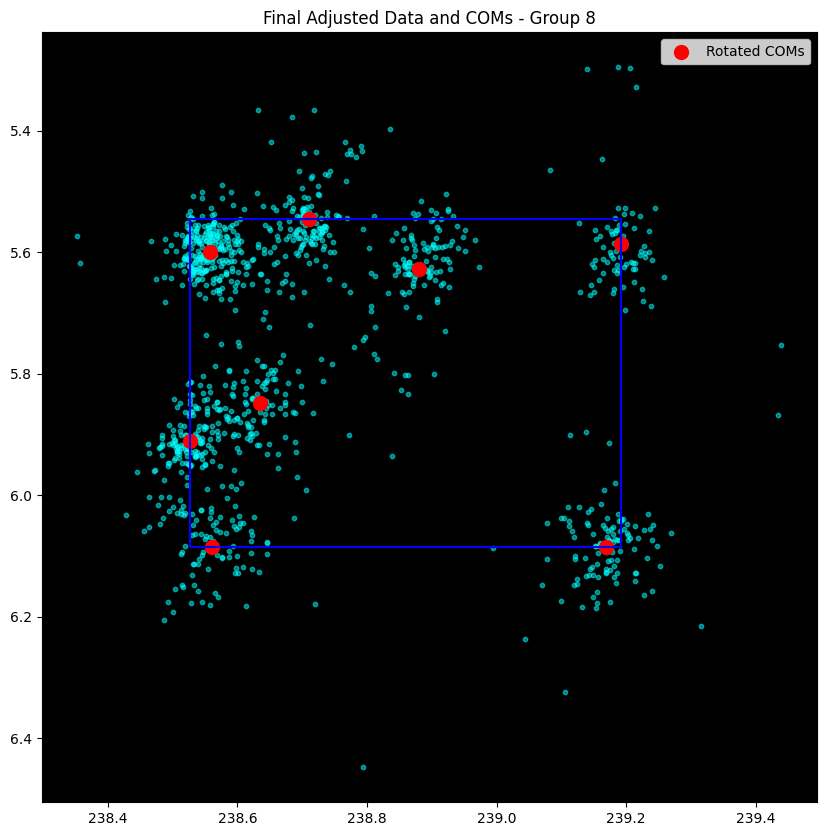

Second Highest COM:
 [238.52735719   5.91147607]
Right Most COM:
 [239.19201292   5.58617956]
Second Right Most COM:
 [239.16949493   6.0847216 ]
Robot COM:
 [238.63527699   5.84770976]


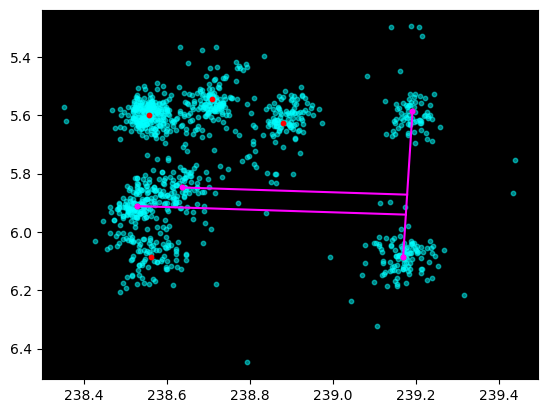

Ratio:
 0.8383913451003757

Processing Group 9
Data collected:
             x          y
0  204.727203  23.444227
1  204.673523  23.472221
2  204.732361  23.457150
3  204.768372  23.501686
4  205.214050  22.981375


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


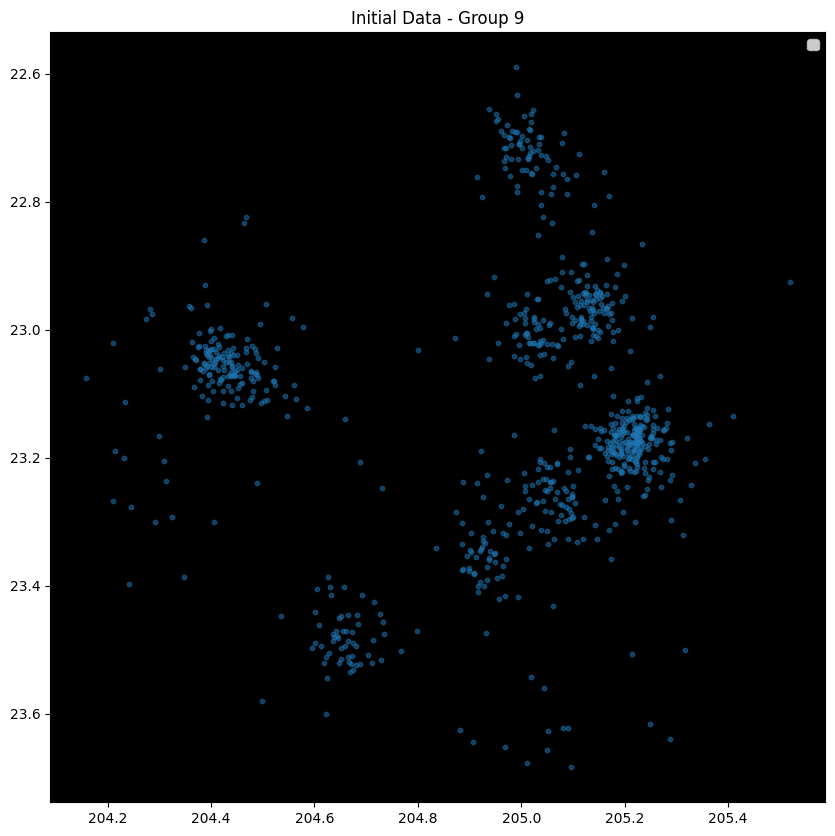

K-Means labels:
 [0 0 0 0 3 3 3 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 1 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 2 2 3 3 6 0 0 0 6 6 6 6 6 6 6 2 2 2 2
 2 2 2 2 3 3 3 6 4 4 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 4 4 4 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 7 0 0 0 0 0 0 0 0 0 0 7 0 6 7 7 7 7
 7 7 7 7 7 7 7 7 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 2 3
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3 5 3 3 3 3 3 3 3 2 3 3 5 5 0 0 3 3 3 1
 1 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 6 1 1 3 3 3 0 0 0 0 2 2 2 2 2 2 2 5 5 5 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 4 1 1 2 2 2 5 5 5 0 0 0 5 5 5 5 5 4 4 4 4 3 3 1 4 1 1 3 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 2 2 2 2 2 2 1 4 4 4 4 4 4 4 6 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 3 3 4 4 4 3 3 2 2 2 2 2
 2 2 2 6 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5
 5 5 5 5

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


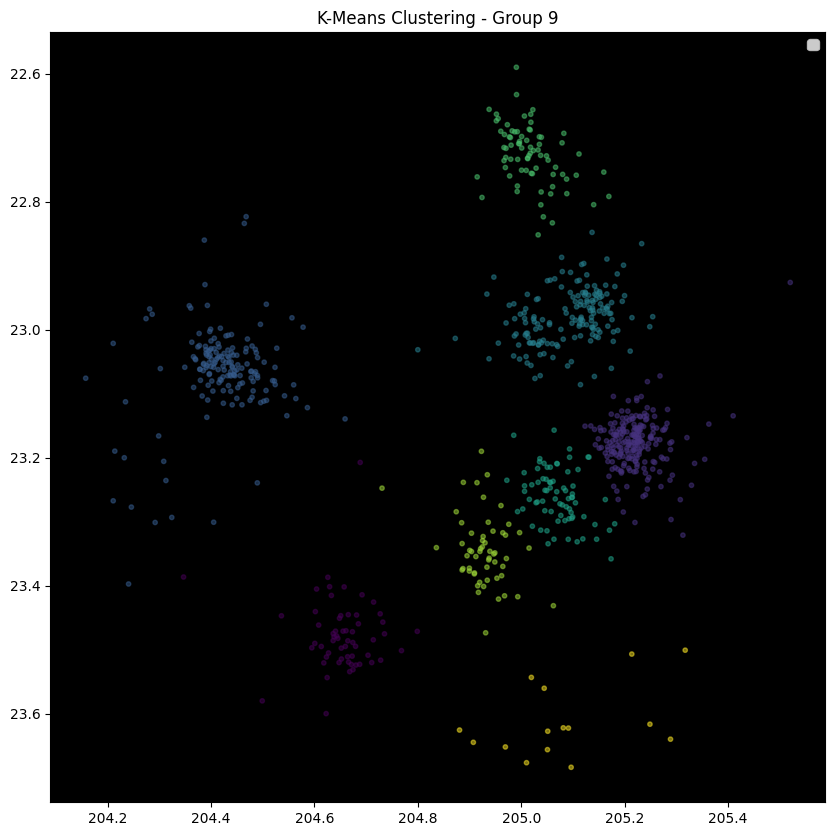

Centers of Mass (COM):
 [(np.float64(204.65355203919492), np.float64(23.476904367996475)), (np.float64(205.220920387758), np.float64(23.177647004433727)), (np.float64(204.42058107329578), np.float64(23.06531200176332)), (np.float64(205.0923733594941), np.float64(22.98025301026135)), (np.float64(205.07086449700432), np.float64(23.26075252326759)), (np.float64(205.01724604556435), np.float64(22.726969543256256)), (np.float64(204.92825971330916), np.float64(23.344874790736608)), (np.float64(205.08466186523438), np.float64(23.61215985616048))]


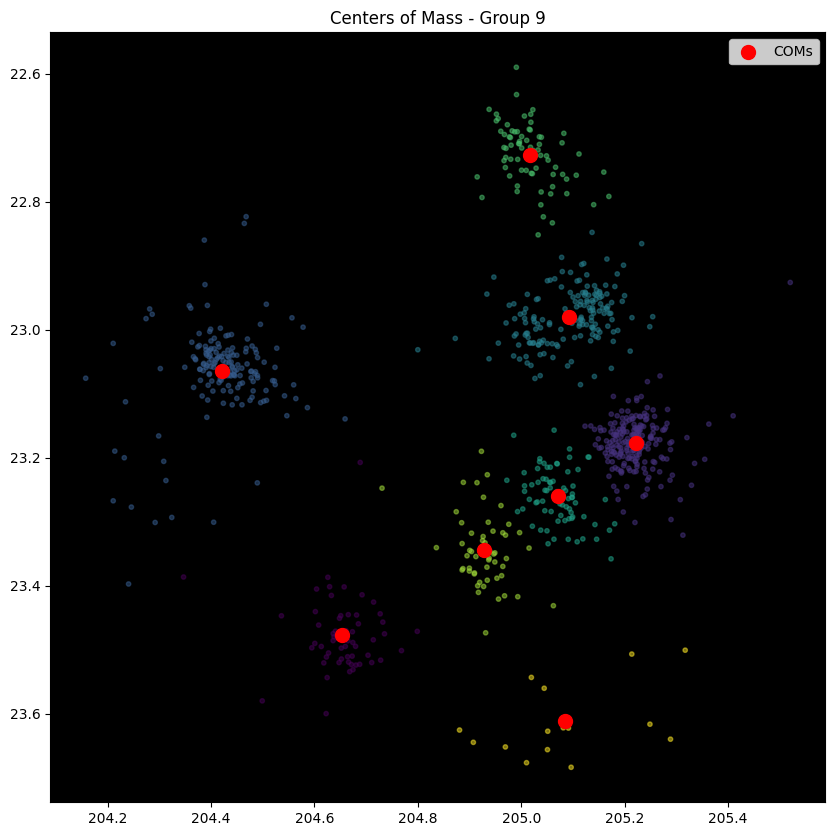

Minimum Bounding Rectangle:
 [[205.41306873  23.42627384]
 [205.01724605  22.72696954]
 [204.42031699  23.06484544]
 [204.81613968  23.76414973]]
Closest side of bounding rectangle:
 0
Closest line start: [205.41306873  23.42627384], end: [205.01724605  22.72696954]
Initial calculated angle: -2.0858583883819595 radians (-119.51088231624598 degrees)
Final rotation angle: 2.0858583883819595 radians (119.51088231624598 degrees)
Rotation angle:
 2.0858583883819595
Rotated Data:
 [[205.73529423  22.82054753]
 [205.73737435  22.76004189]
 [205.72150794  22.81867051]
 [205.66501094  22.82807107]
 [205.89828185  23.47222796]]
Rotated Centers of Mass (COM):
 [[205.74313636  22.74035517]
 [205.72408939  23.38152521]
 [206.21608853  22.74035517]
 [205.95919475  23.36688968]
 [205.72568167  23.2100004 ]
 [206.21662464  23.42627384]
 [205.72271877  23.04445916]
 [205.41306873  23.04890839]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 5.227451041971753 radians (299.510882316246 d

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


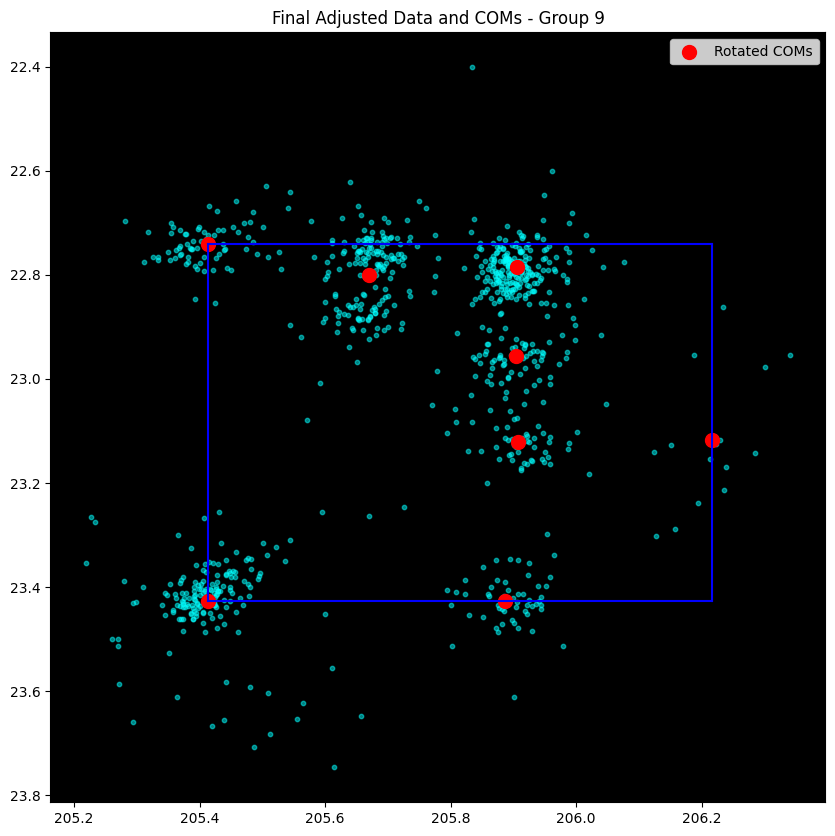

Second Highest COM:
 [205.67049863  22.79973933]
Right Most COM:
 [206.21662464  23.11772062]
Second Right Most COM:
 [205.90697461  23.12216985]
Robot COM:
 [205.90697461  23.12216985]


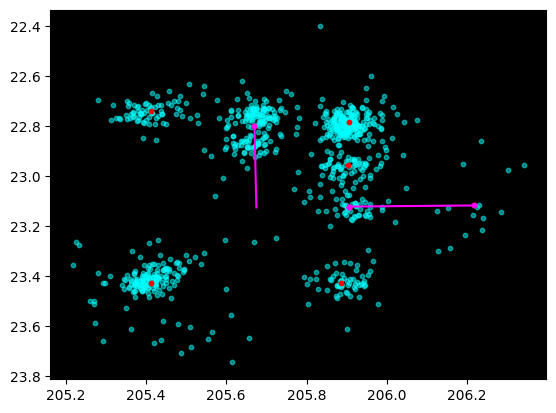

Ratio:
 0.0


OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

<Figure size 1000x600 with 0 Axes>

In [70]:
# Example usage
filename = 'data/n=10_origmi_locs.hdf5'
k = 8
process_multiple_origami_ratio(filename, k)